# Pre-MAP 2019 Final Notebook

###### Import Statements

In [142]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import tarfile
import sqlite3
import lsst.daf.persistence as dafPersist
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags

### Interfacing with HiTS and LSST Data

###### HiTS Data

In [143]:
hitsDataDir='/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename='HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath=os.path.join(hitsDataDir,hitsFilename) # Creates file path to the HiTS DR1 database
hitsTable=fits.open(hitsFilepath) # Load data as an astropy fits thing
hitsDf=pd.DataFrame(hitsTable[1].data) # Turn data into a pandas dataframe

###### LSST Data

In [144]:
repo = '/epyc/users/mrawls/premap2019/hits-lsst/hits2015/rerun/highres1'
butler = dafPersist.Butler(repo) # Butler function retrieves the data
dbName = 'association.db'
dbPath = os.path.join(repo, dbName) # Joins repo and dbName to form a path to the database
connection = sqlite3.connect(dbPath) # Opens a connection to the database

# Read data from the database to pandas dataframes
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection) 
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

###### Filtering and Converting the Data

In [145]:
# Applies filters to srcTableAll and objTable with function written by Dr. Rawls.
badFlagList = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_saturatedCenter'] 
flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTableAll, objTable)

# Disregard error message

/epyc/users/mrawls/lsst_stack/stack/miniconda3-4.5.12-f032070/Linux64/ap_association/18.1.0-14-g371438c+1/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [146]:
lsstRas = goodObj.ra
lsstDecs = goodObj.decl
hitsRas = hitsDf.raMedian_feat
hitsDecs = hitsDf.decMedian_feat
# Convert HiTS and LSST coordinates to degrees
hitsCoords = SkyCoord(ra=hitsRas*u.degree, dec=hitsDecs*u.degree)
lsstCoords = SkyCoord(ra=lsstRas*u.degree, dec=lsstDecs*u.degree)
idx, d2d, d3d = hitsCoords.match_to_catalog_sky(lsstCoords) # matches indices between the dataframes

### Plotting Objects on the Sky

In [147]:
def plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second):
    """This function takes two sets of RA and Dec and plots them
    both on the sky in different colors.
    
    It is customized to plot a specific region (three HiTS fields in two panels).
    
    "1" and "2" refer to the two panels in the plot.
    "first" and "second" refer to the two different datasets.
    """
    # Set up the figure object and two axes
    fig = plt.figure(figsize=(13, 13))
    ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)
    ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)

    # Plot the first set of RAs and Decs in blue
    # This will be from the LSST database
    ax1.scatter(ra1_first, dec1_first, marker='.', s=0.5, alpha=0.5, c='C0',label='LSST')
    ax2.scatter(ra2_first, dec2_first, marker='.', s=0.5, alpha=0.5, c='C0',label='LSST')
    
    # Plot the second set of RAs and Decs in red
    # This will be from the HiTS DR1
    ax1.scatter(ra1_second, dec1_second, marker='.', s=10, alpha=0.8, c='red',label='HiTS')
    ax2.scatter(ra2_second, dec2_second, marker='.', s=10, alpha=0.8, c='red',label='HiTS')

    ax1.invert_xaxis()
    ax2.invert_xaxis()
    
    # Label axes and title plot
    plt.xlabel('RA (deg)', fontsize=14)
    plt.ylabel('Dec (deg)', fontsize=14)
    plt.title('View of Objects from LSST and HiTS on the Sky', fontsize=15.5)
    
    # Increase x and y tick text size
    ax1.tick_params(axis='both', which='major', labelsize=11.5)
    ax1.tick_params(axis='both', which='minor', labelsize=11.5)

    ax2.tick_params(axis='both', which='major', labelsize=11.5)
    ax2.tick_params(axis='both', which='minor', labelsize=11.5)
    
    # Generate legends
    lgnd = ax1.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    lgnd.legendHandles[0]._sizes = [60]
    lgnd.legendHandles[1]._sizes = [60]
    
    lgnd2 = ax2.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    lgnd2.legendHandles[0]._sizes = [60]
    lgnd2.legendHandles[1]._sizes = [60]

In [148]:
# Defines filters and parameters to be called by plot_objects_on_sky()
ax1Filter = (goodObj['decl']>-2)
ax2Filter=(~ax1Filter)

ra1_first=goodObj.loc[ax1Filter, 'ra']
dec1_first=goodObj.loc[ax1Filter, 'decl']
ra2_first=goodObj.loc[ax2Filter, 'ra']
dec2_first=goodObj.loc[ax2Filter, 'decl']

ax1Filter_second = (hitsDf['decMedian']>-2)
ax2Filter_second = (~ax1Filter_second)

ra1_second=hitsDf.loc[ax1Filter_second,'raMedian']
dec1_second=hitsDf.loc[ax1Filter_second,'decMedian']
ra2_second=hitsDf.loc[ax2Filter_second,'raMedian']
dec2_second=hitsDf.loc[ax2Filter_second,'decMedian']

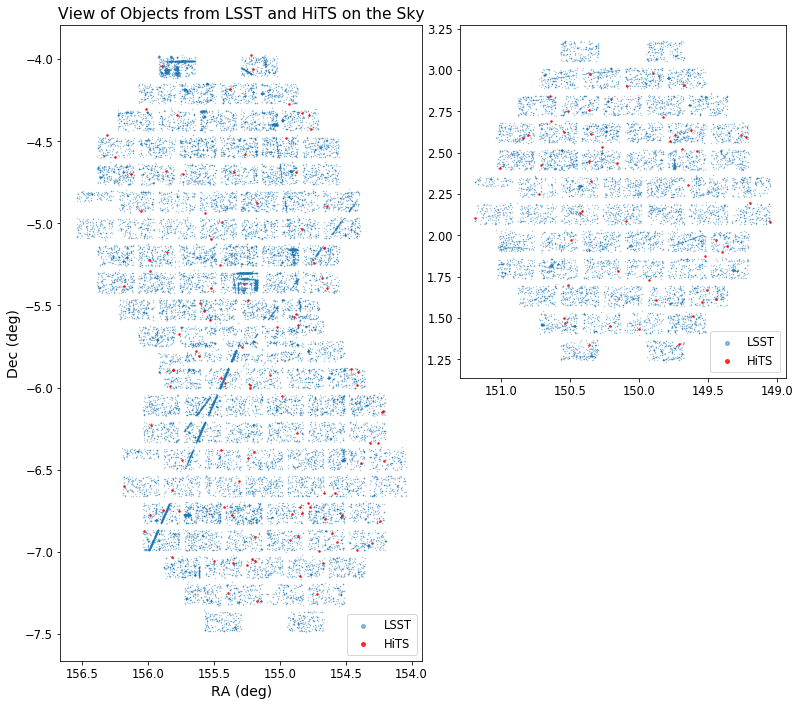

In [149]:
plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second)

### Plotting Light Curves

In [150]:
# Converts flux measurements and flux error to magnitude so LSST and HiTS data can be plotted together
srcTableArray = np.array(srcTableAll['totFlux'])
mag = (srcTableArray*u.nJy).to(u.ABmag)
magErr = np.abs(-1.0857/srcTableAll['totFluxErr']/srcTableAll['totFlux'])

# Append srcTableAll with new magnitude and magnitude error columns.
srcTableAll['magCol'] = mag
srcTableAll['magErrCol'] = magErr

##### Talk to Dr. Rawls about this error message ####

/epyc/users/mrawls/lsst_stack/python/miniconda3-4.5.12/envs/lsst-scipipe-f032070/lib/python3.7/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [151]:
def plotLsstHitsLightCurve(obj, srcTable, row, lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves'):
    '''Plots a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database) and a light curve of the same index from HiTS DR1.
    
    Parameters
    ----------
    obj : diaObjectId
        a really long integer that lets us retrieve sources for a single object
    srcTable : Pandas dataframe containing DIA Objects
    row: specific row from the dataframe
    lcPath: path to the light curves within HiTS DR1
    ''' 
    plt.figure(figsize=(10,8))
    # Plot LSST curve
    srcRowFilter = (srcTable['diaObjectId'] == obj)
    srcRow = srcTable.loc[srcRowFilter]
    plt.errorbar(srcRow['midPointTai'], srcRow['magCol'], yerr=srcRow['magErrCol'],
                 ls=':', marker='o', label='LSST')
    
    # PLot HiTS Curve
    tok = row['internalID'].split('_')
    field = '_'.join([tok[0],tok[1]])
    ccd = tok[2]
    lightcurveFile = field + '_' + ccd + '_LC_50.tar.gz'
    tarball = tarfile.open(os.path.join(lcPath,field,ccd,lightcurveFile))
    data = tarball.extractfile(str(row['internalID'])+ '_g.dat')
    dfl = pd.read_csv(data,sep='\t') # lead a file with a light curve data into a pandas dataframe
    plt.errorbar(dfl.MJD,dfl.MAG_AP1,dfl.MAGERR_AP1, marker='o',linestyle=':', label='HiTS')
    
    # Label axes and title plot, increase x and y tick size
    plt.title('Light Curve for HiTS and LSST Objects', fontsize=16)
    plt.ylabel('Apparent Magnitude',fontsize=14)
    plt.xlabel('Time (MJD)',fontsize=14)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    # Generate legend
    plt.legend(prop={'size': 15})

In [152]:
# select object and row from dataframes (indices range from 0-164 and must match)
obj = goodObj.iloc[idx[2]]['diaObjectId']
row = hitsDf.iloc[2]

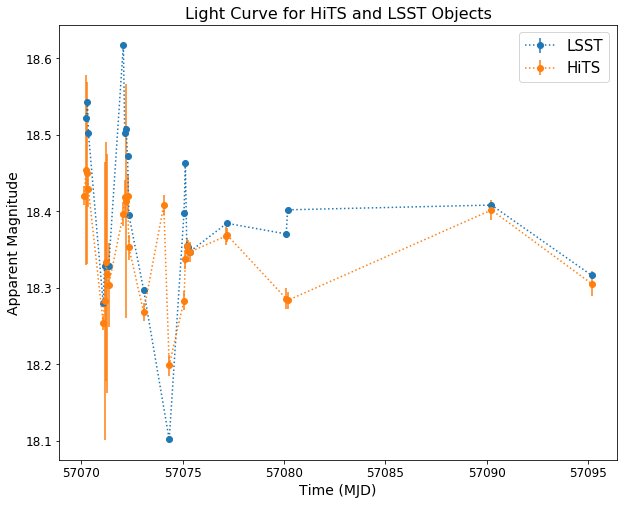

In [153]:
plotLsstHitsLightCurve(obj, srcTableAll, row)

### Identifying Bad Data

#### Preliminary Identification of Good and Bad Curves

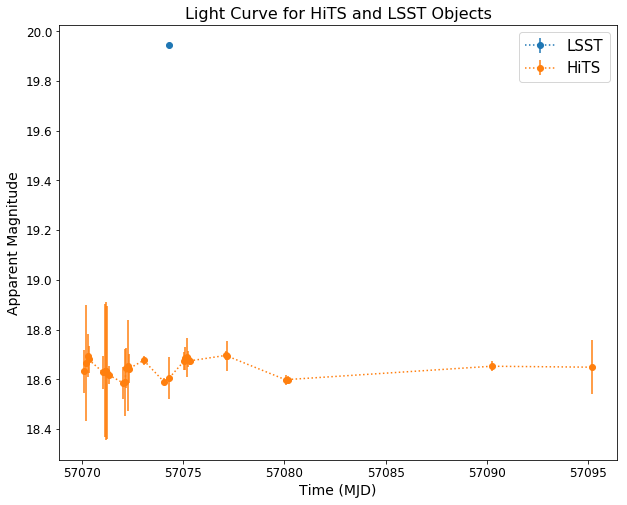

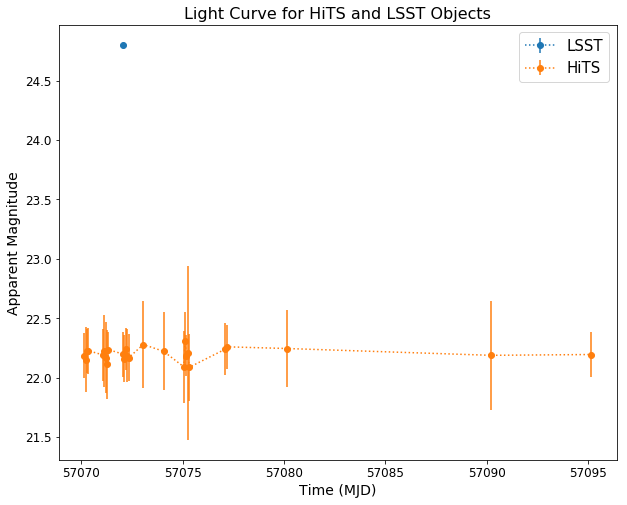

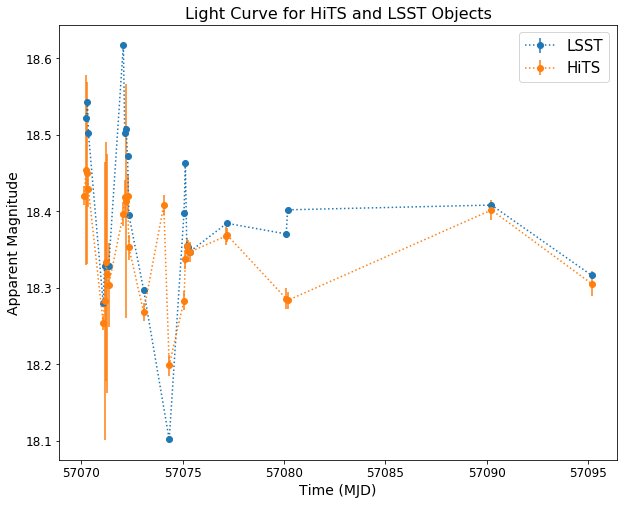

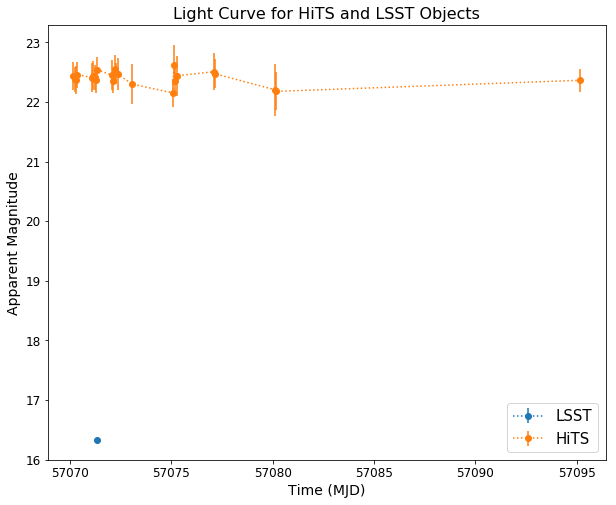

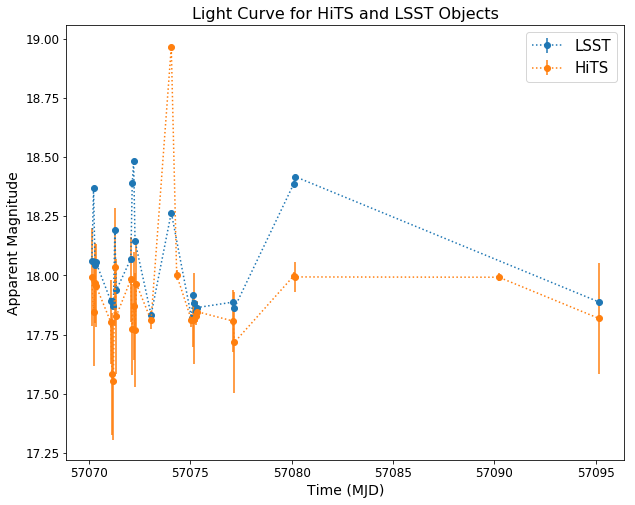

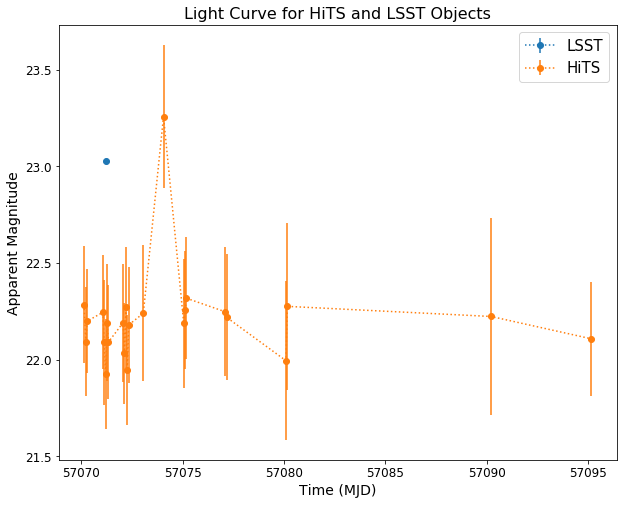

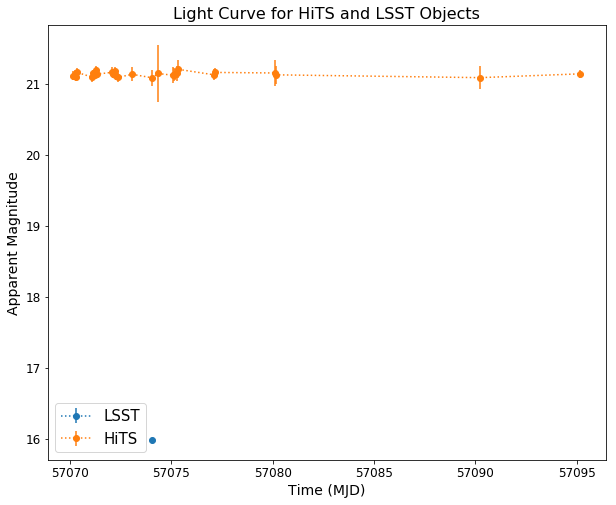

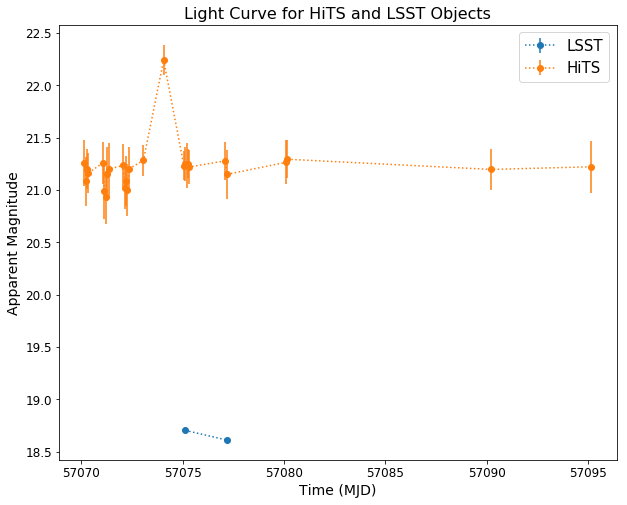

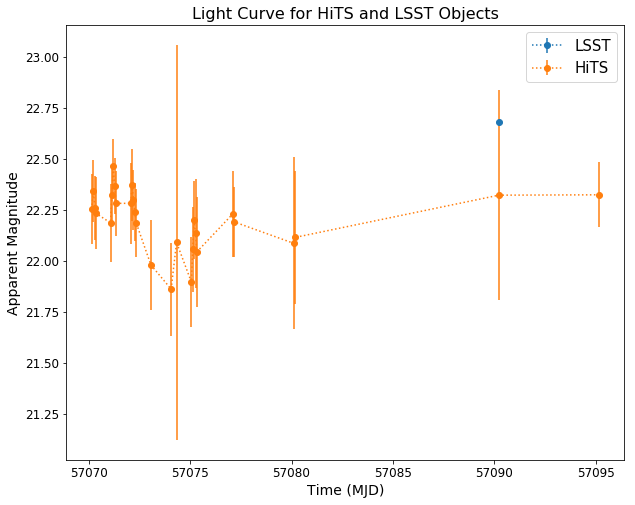

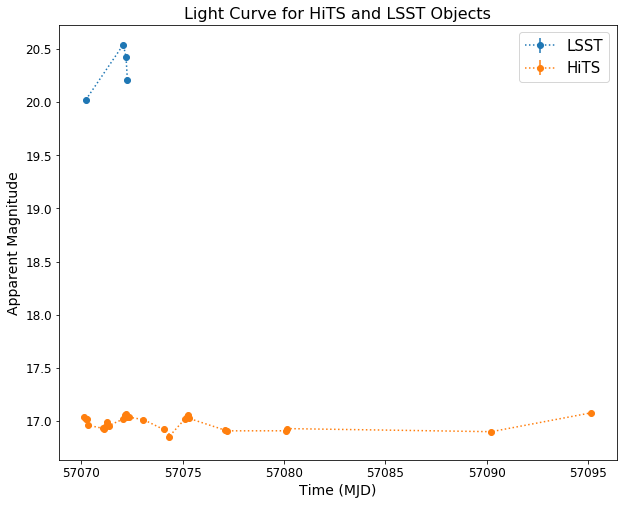

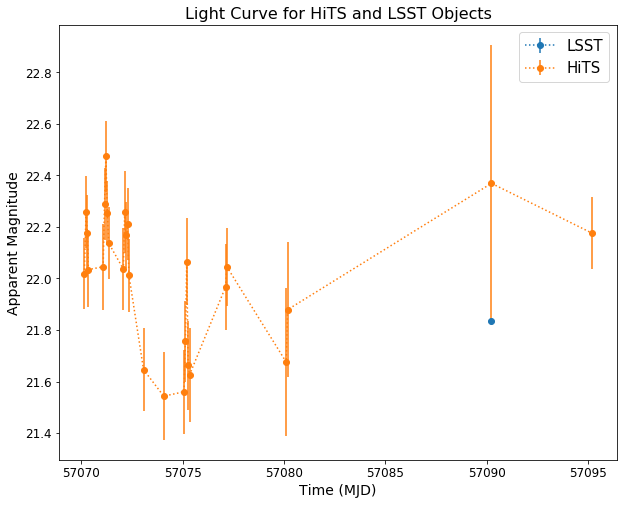

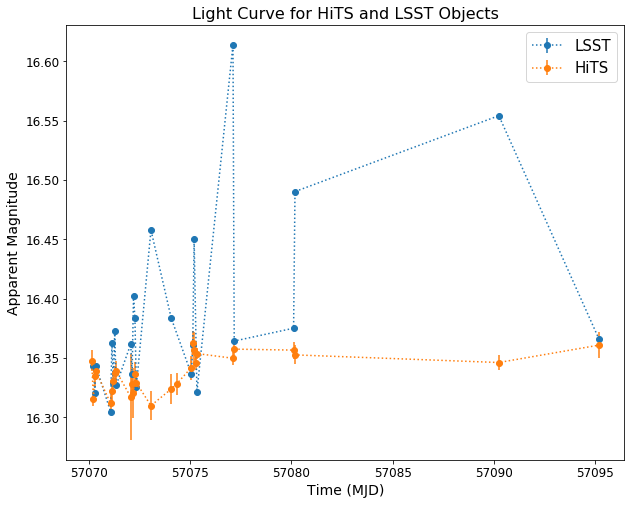

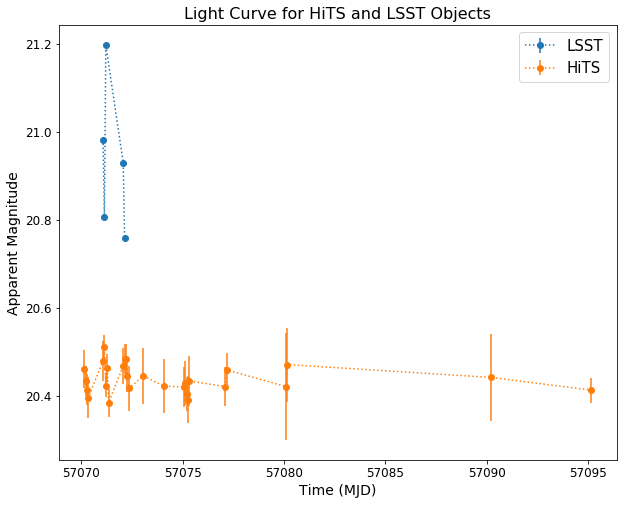

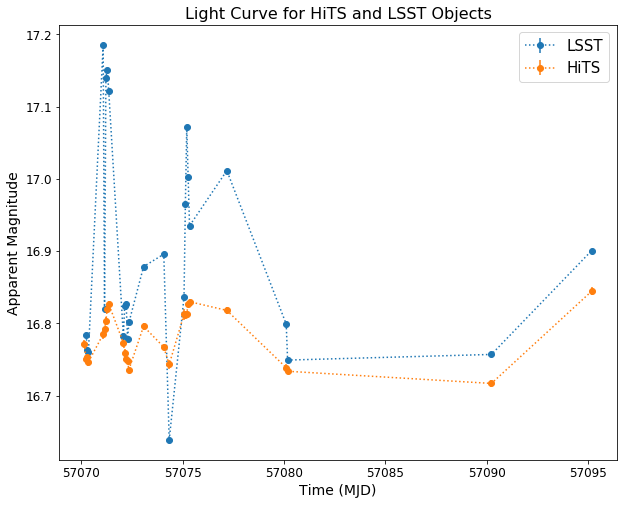

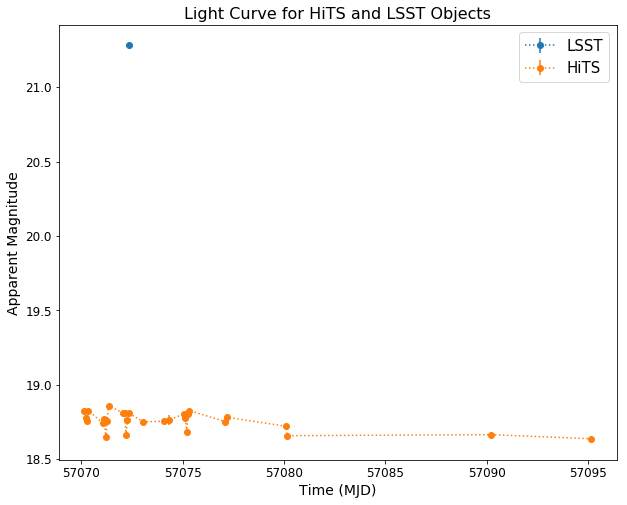

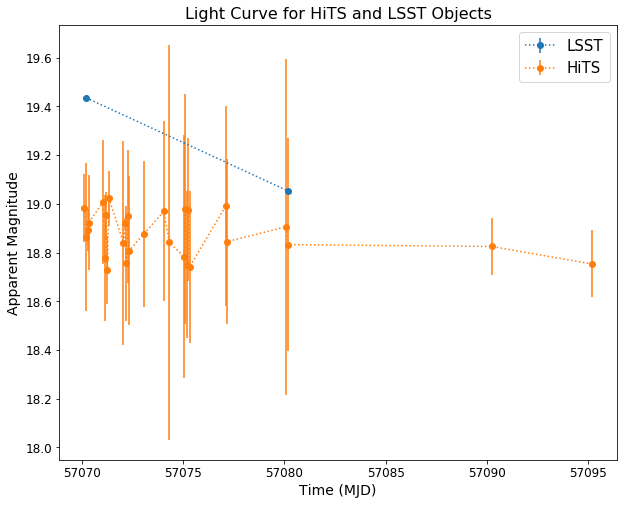

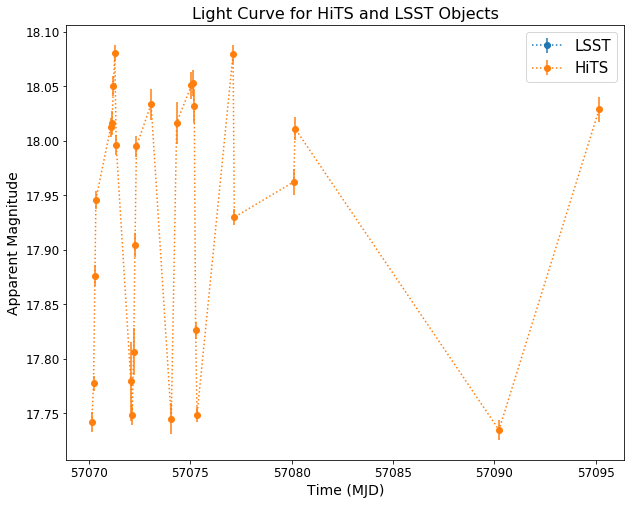

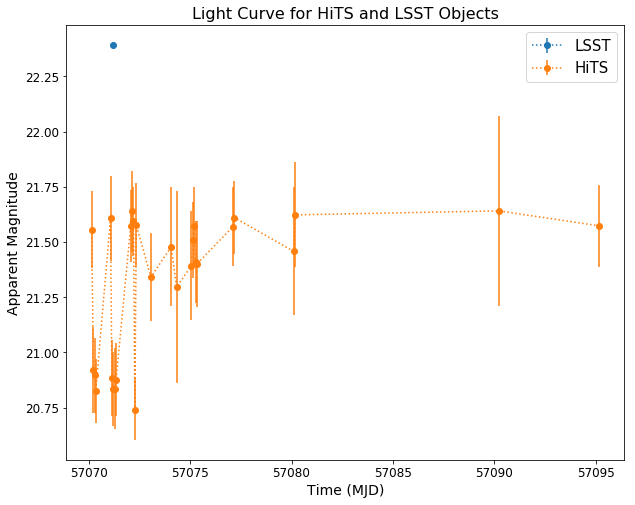

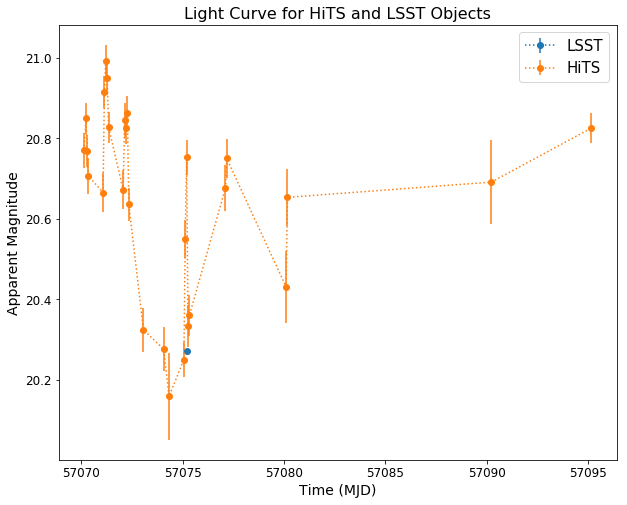

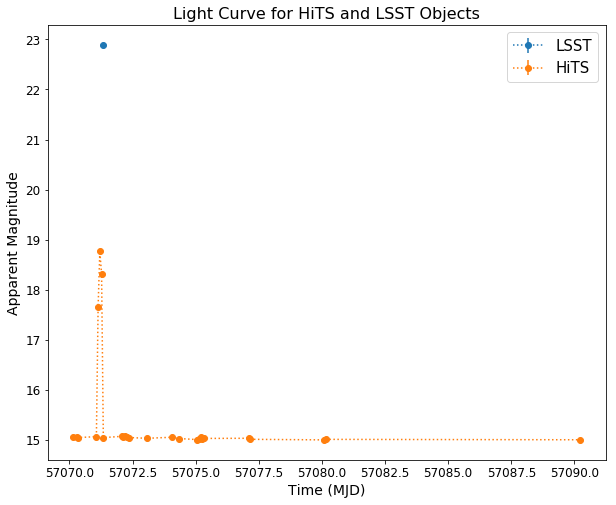

In [154]:
for i in range(0,20): # Plotting multiple light curves
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)    

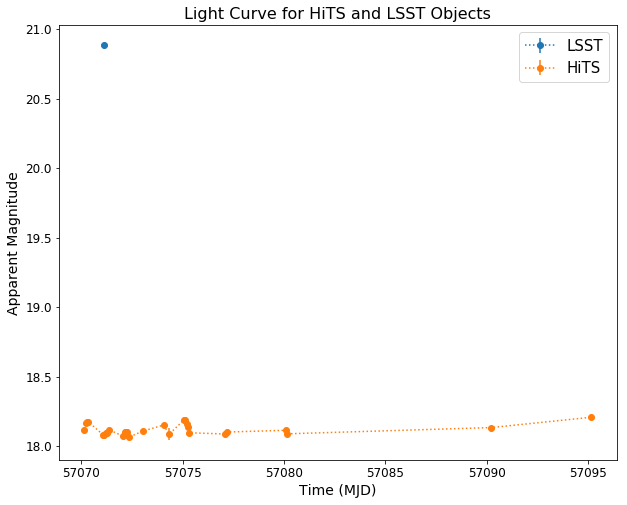

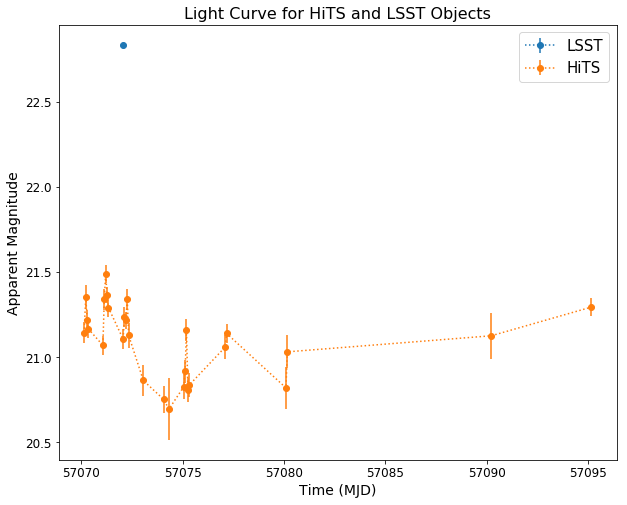

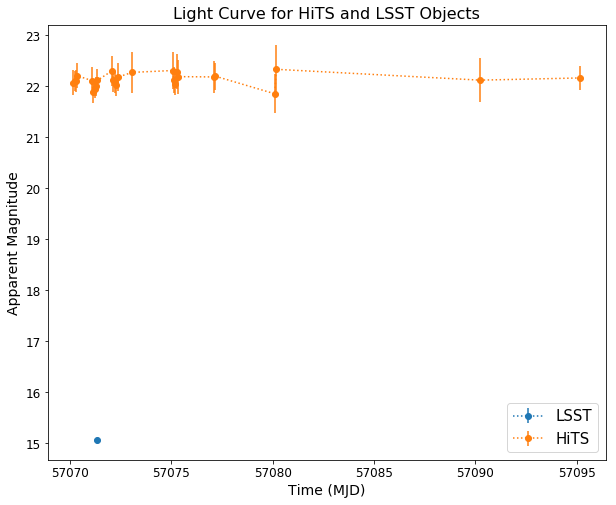

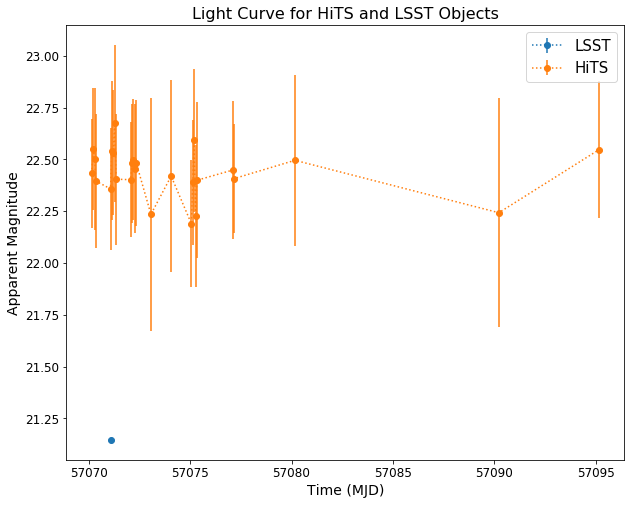

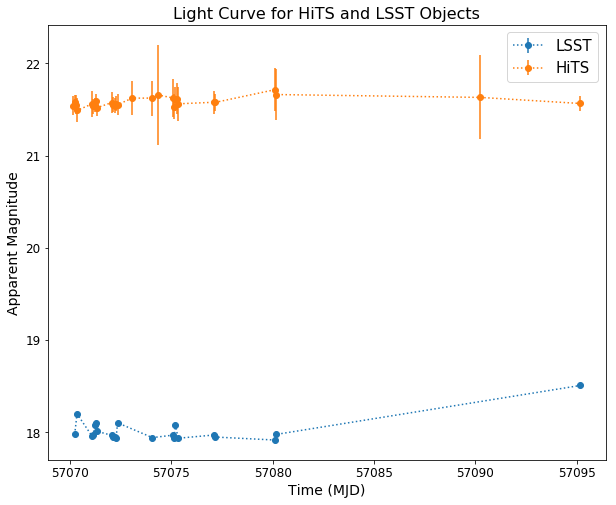

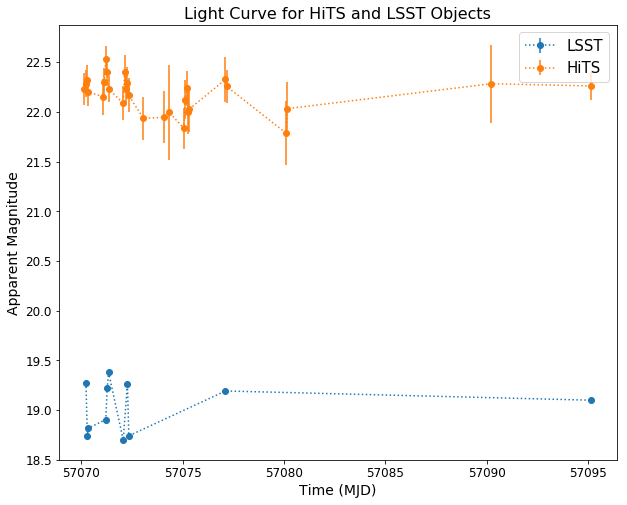

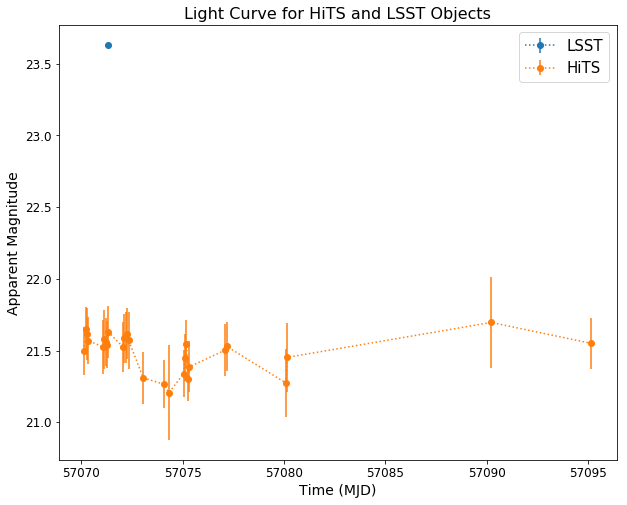

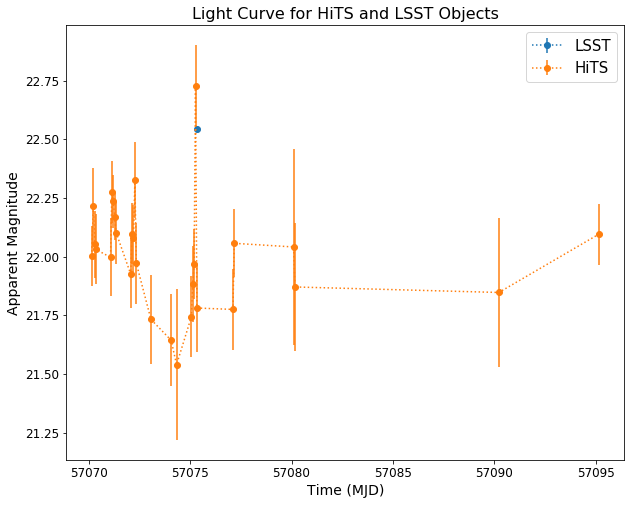

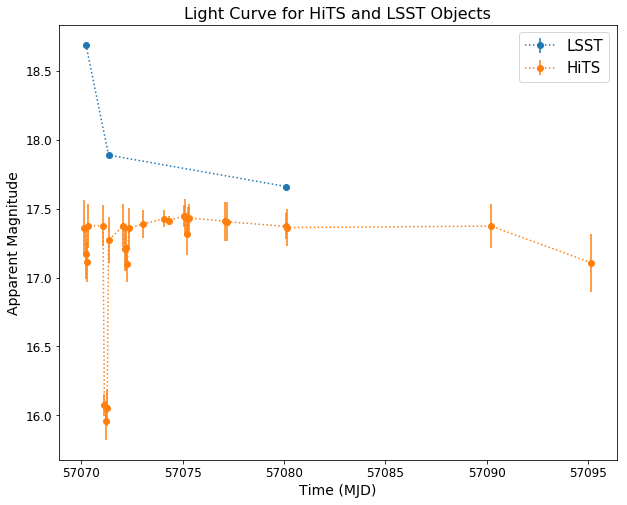

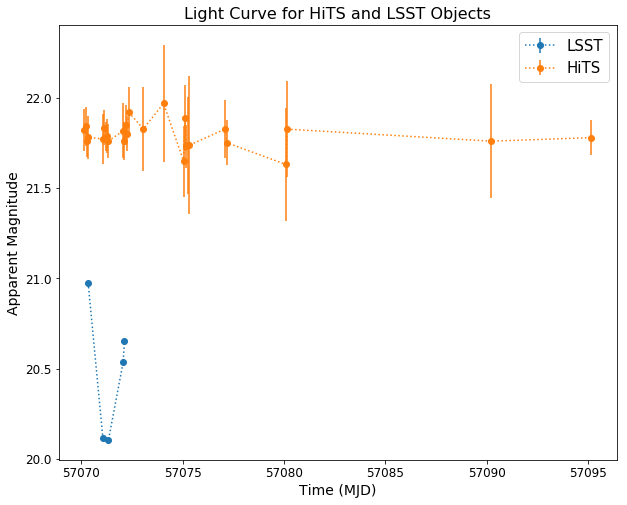

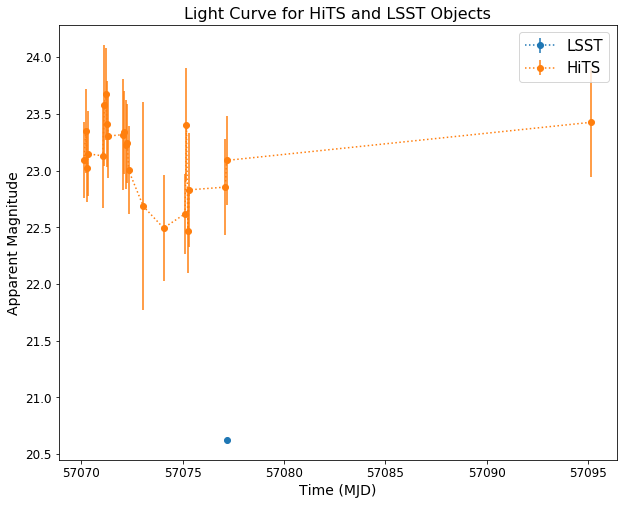

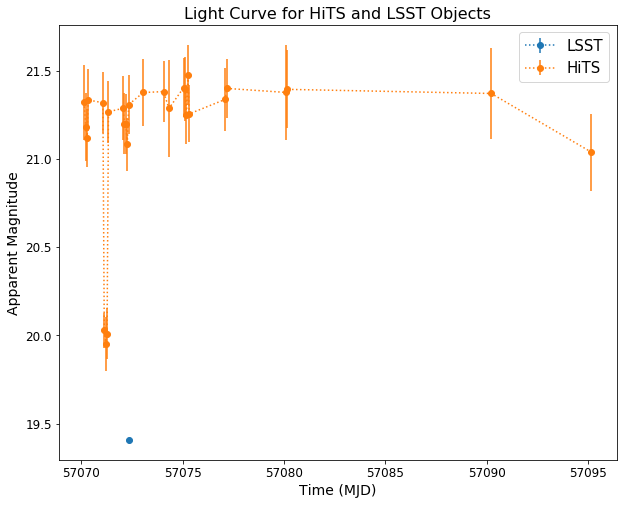

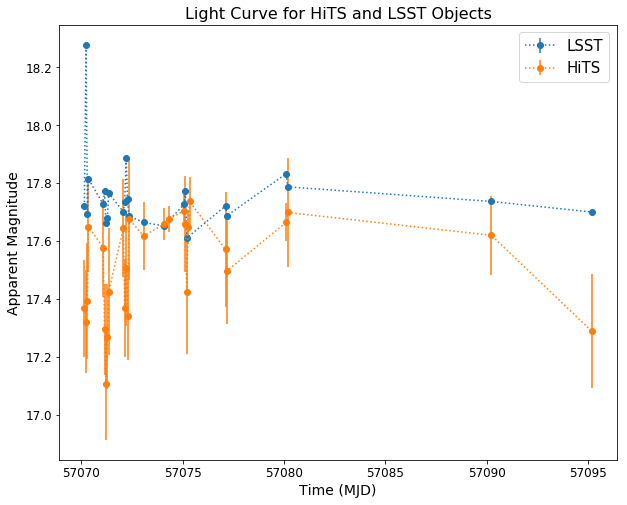

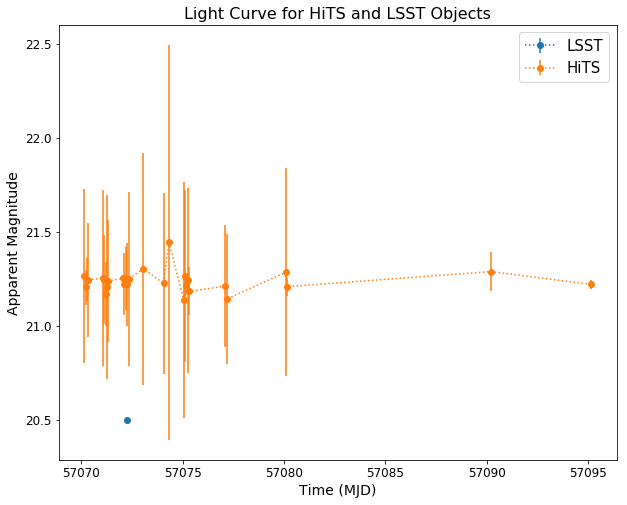

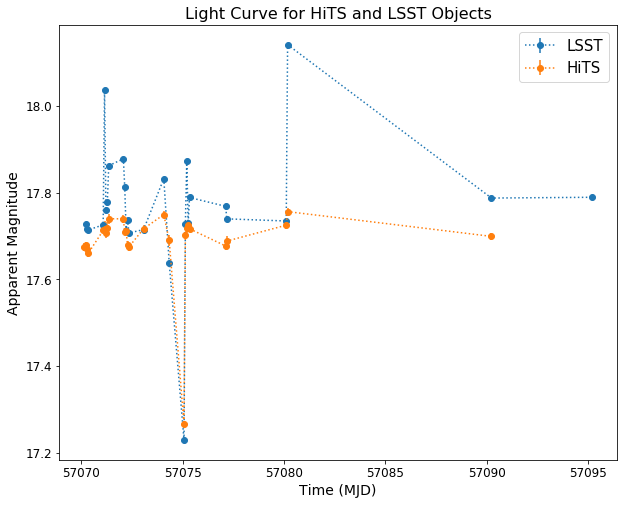

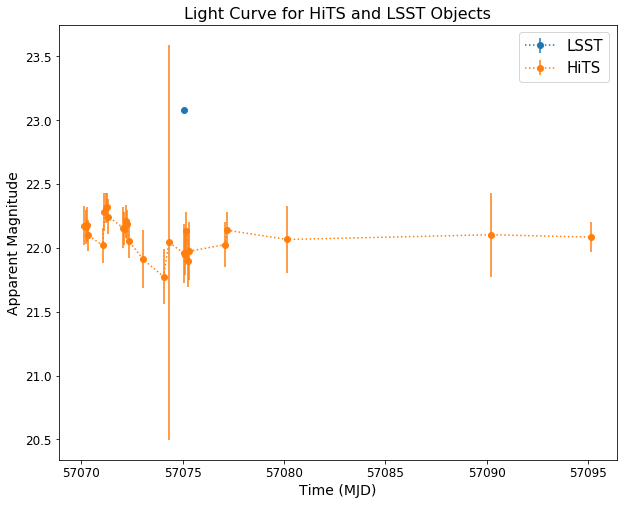

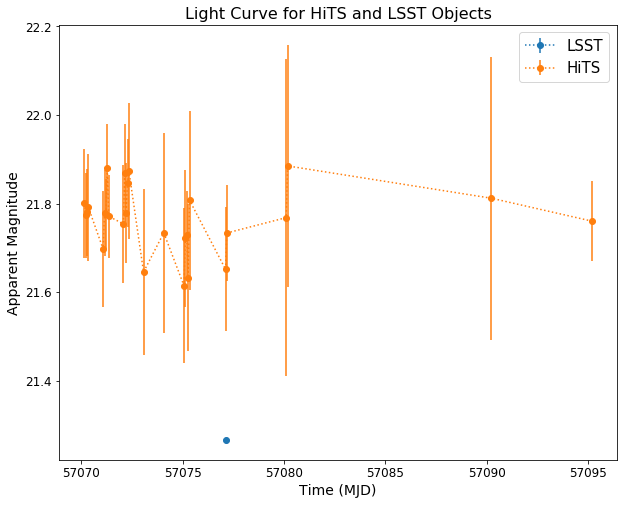

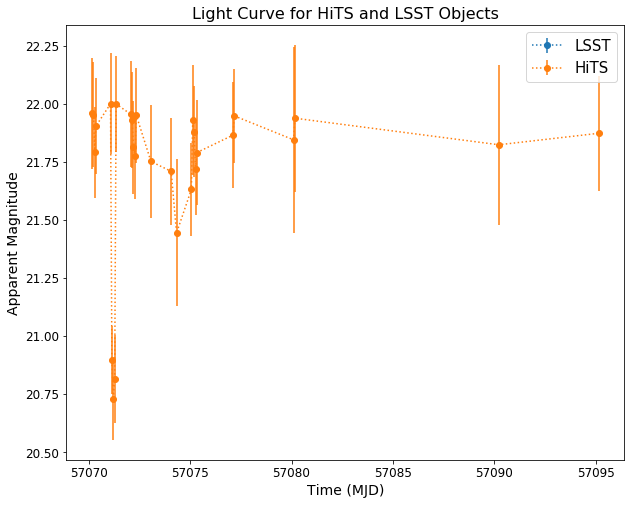

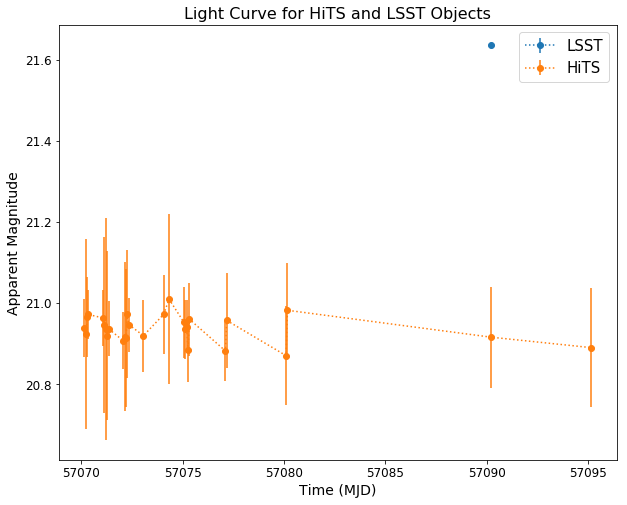

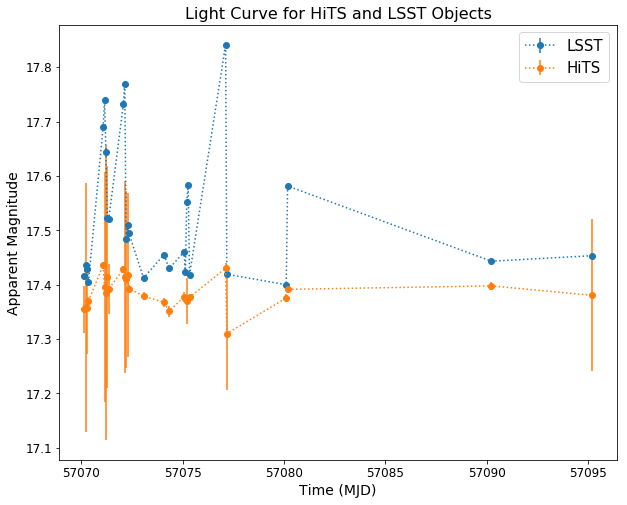

In [155]:
for i in range(20, 40):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

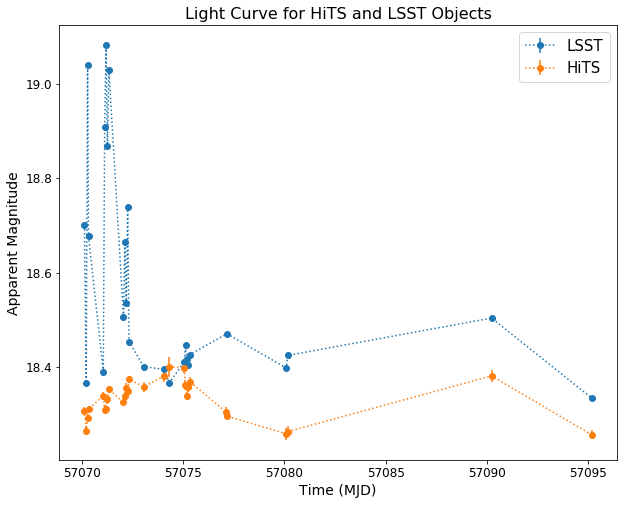

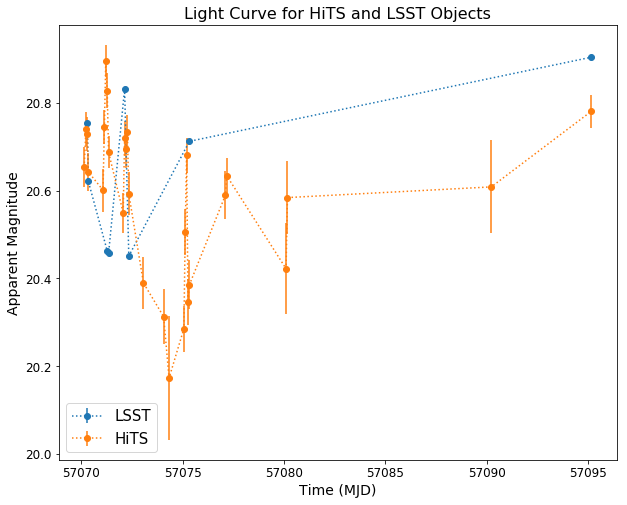

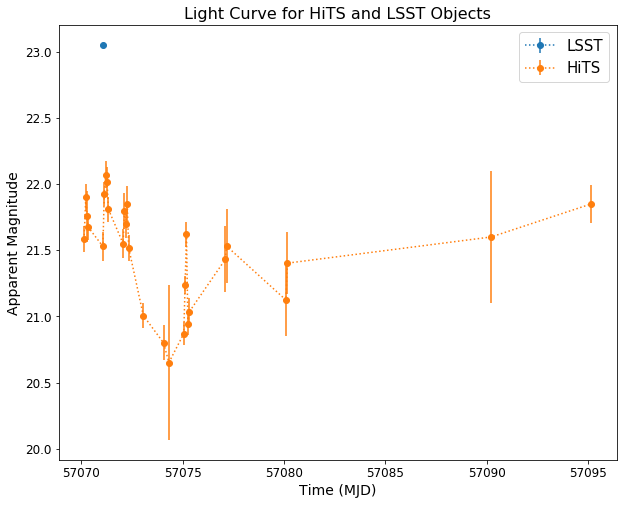

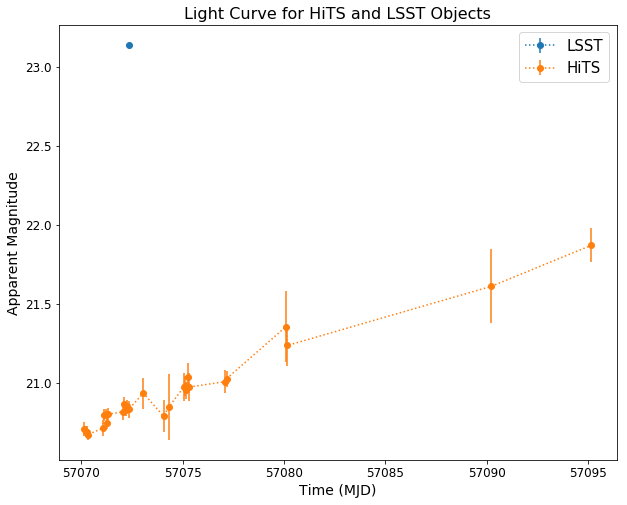

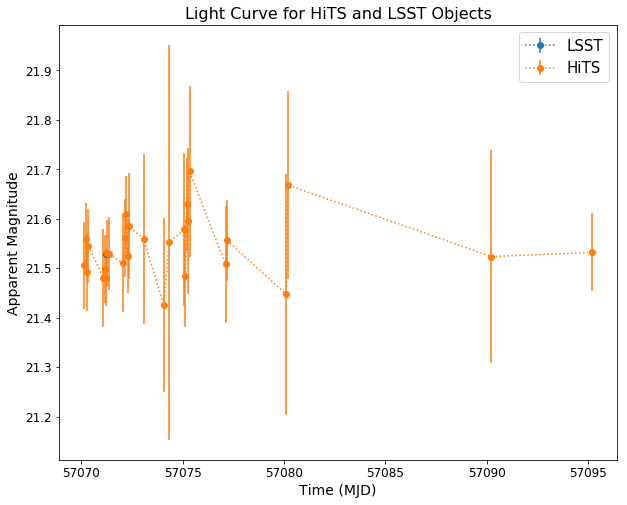

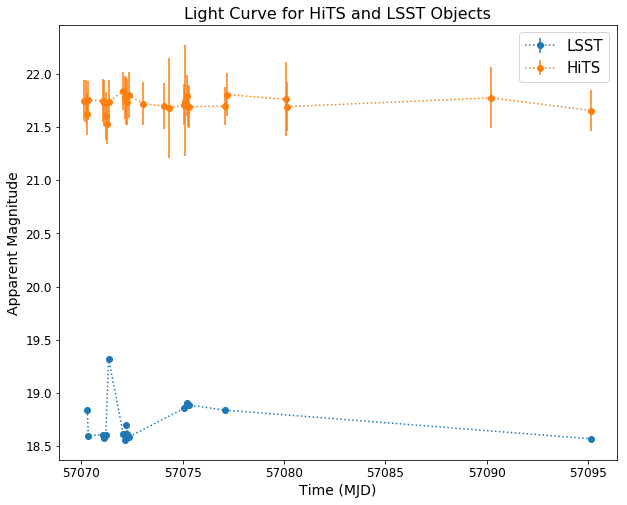

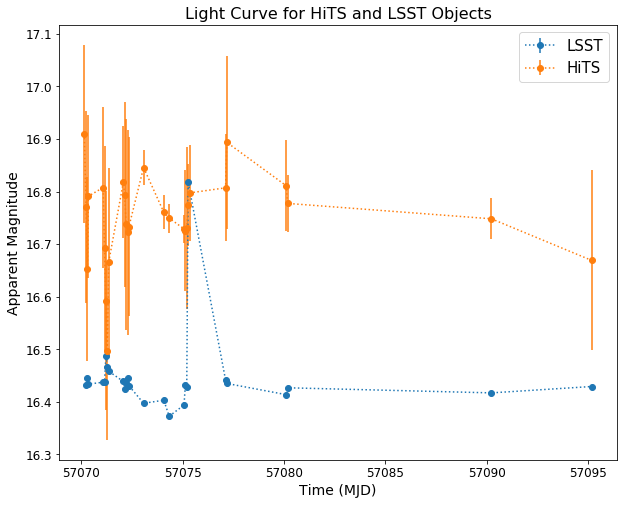

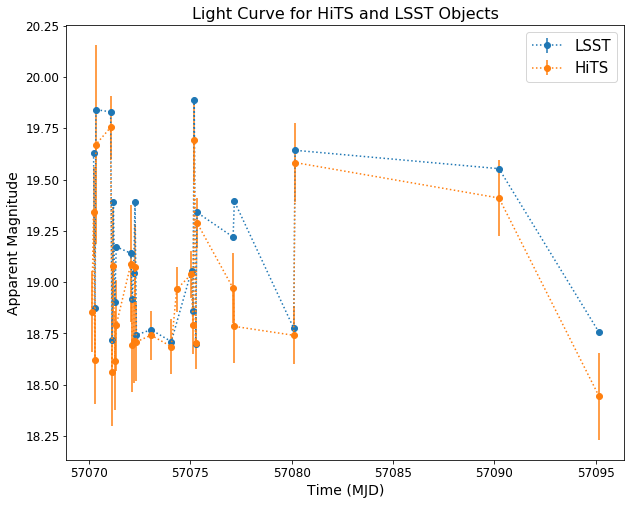

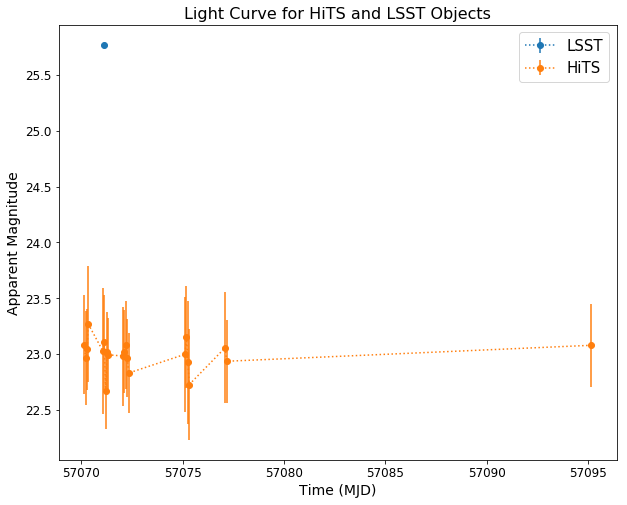

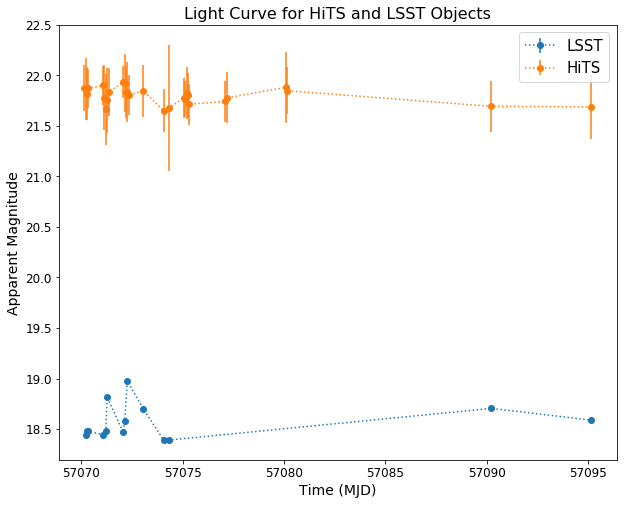

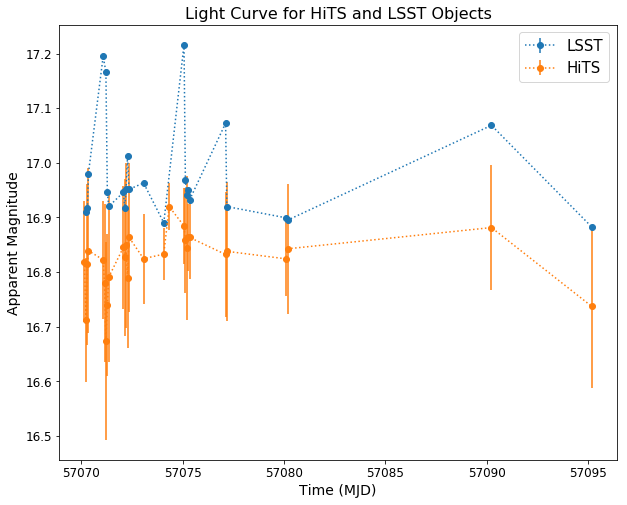

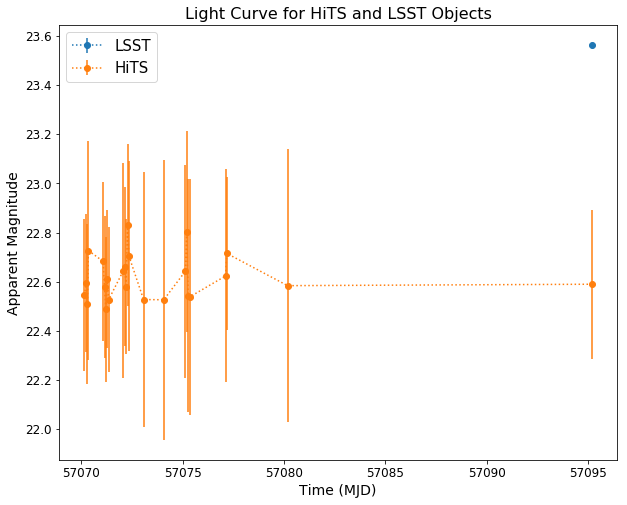

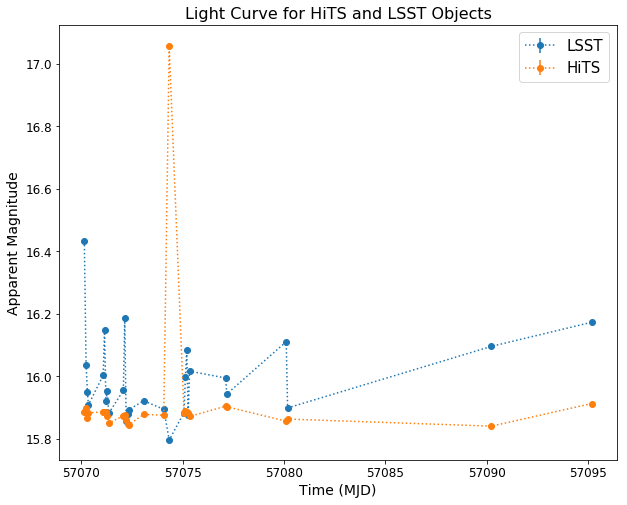

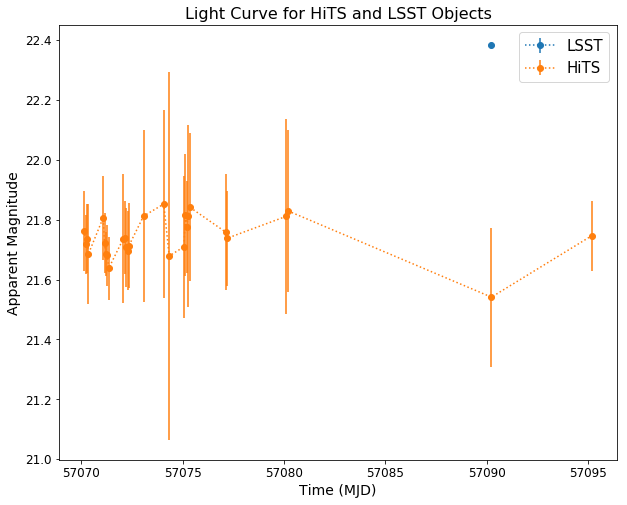

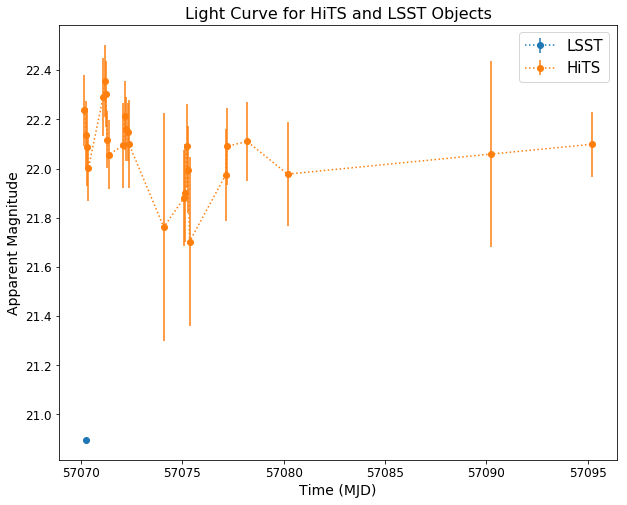

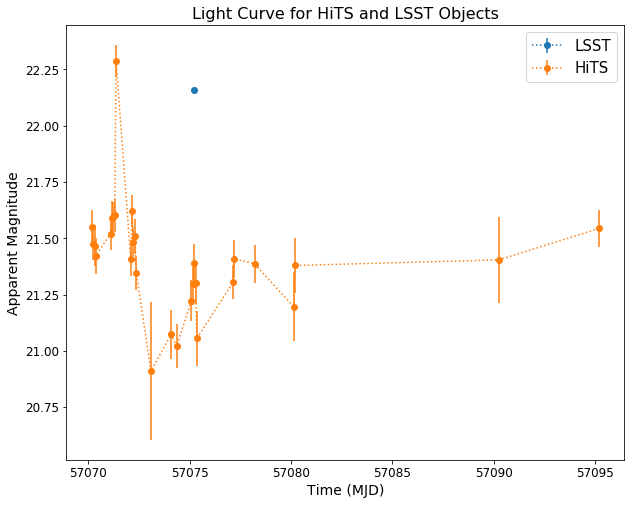

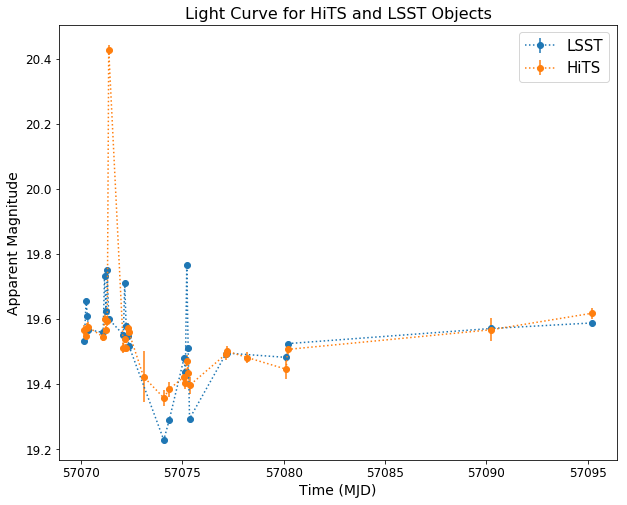

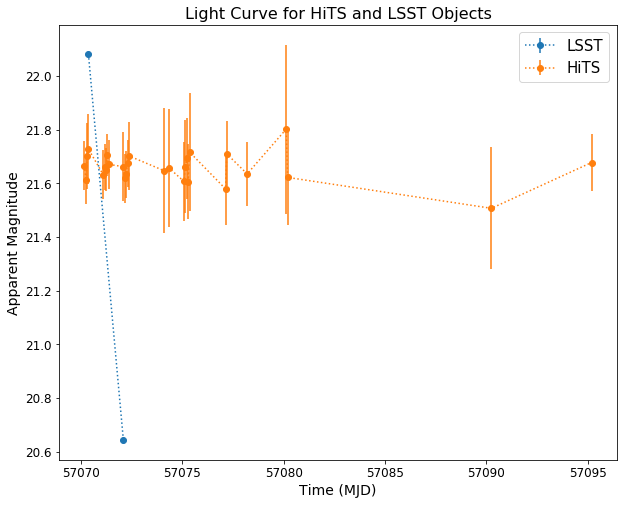

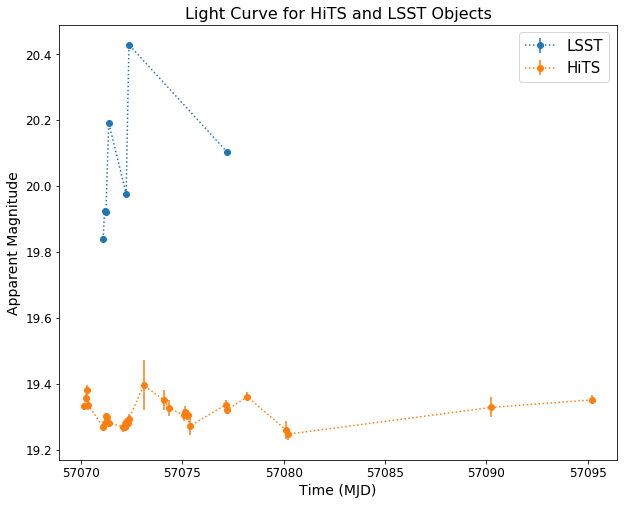

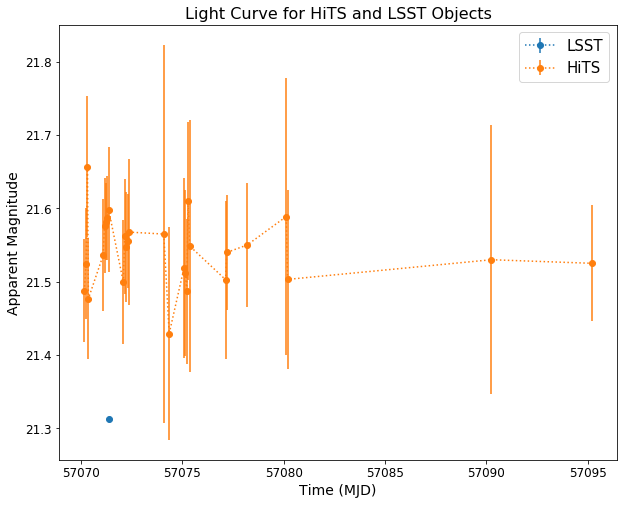

In [156]:
for i in range(40, 60):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

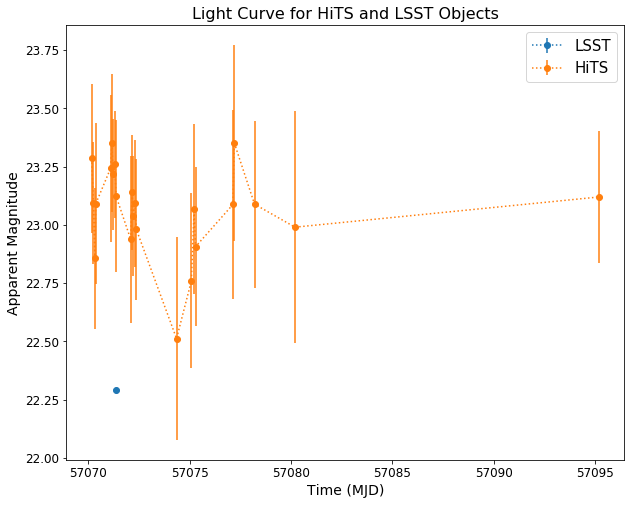

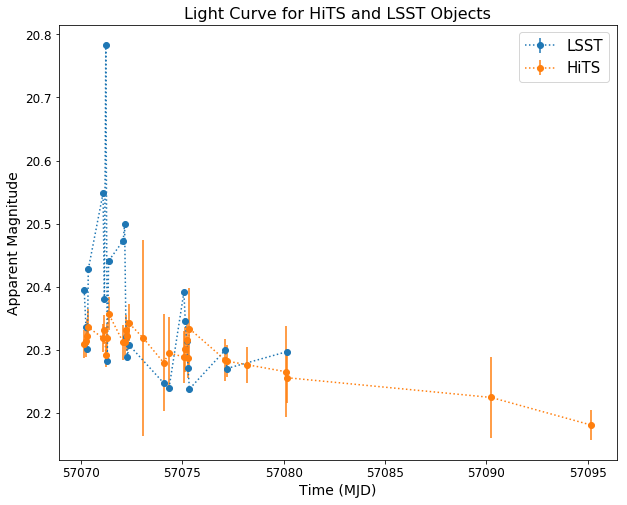

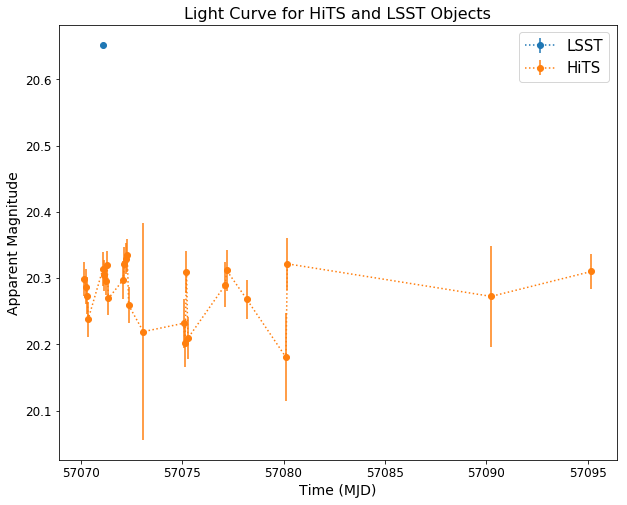

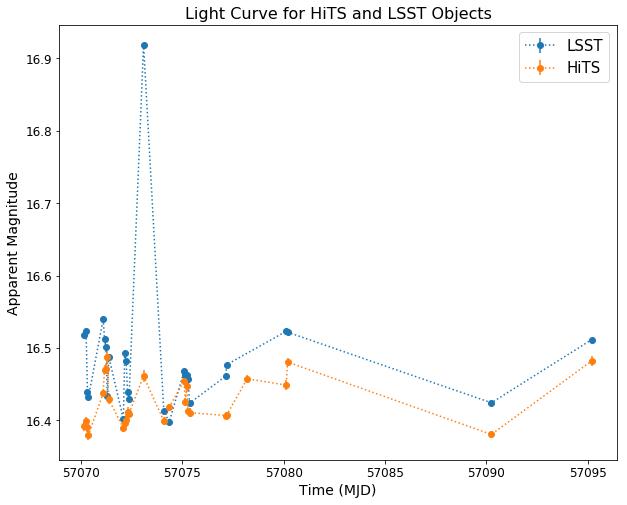

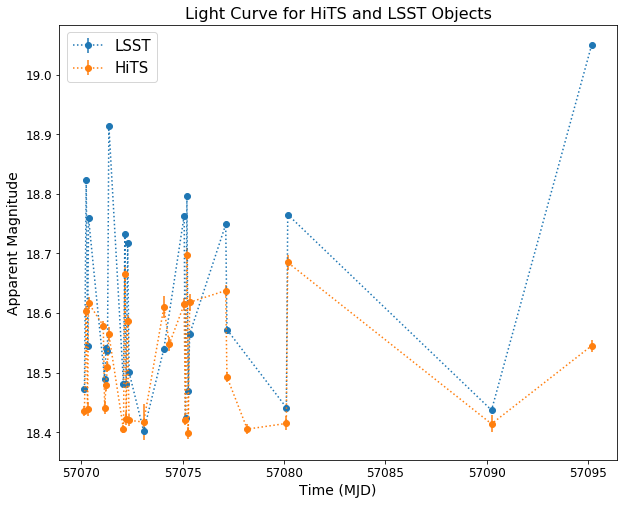

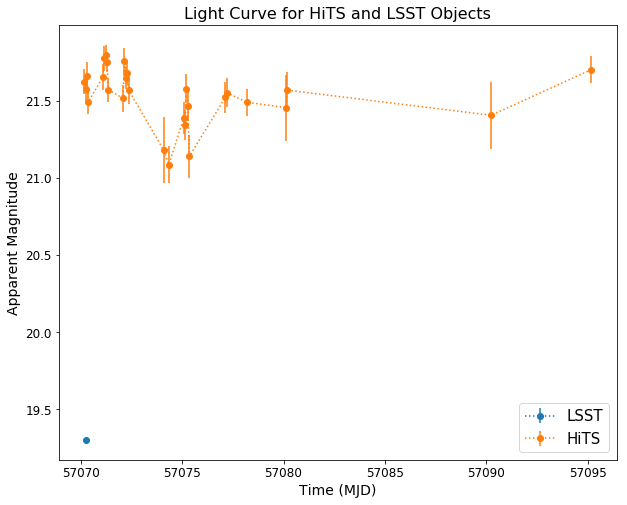

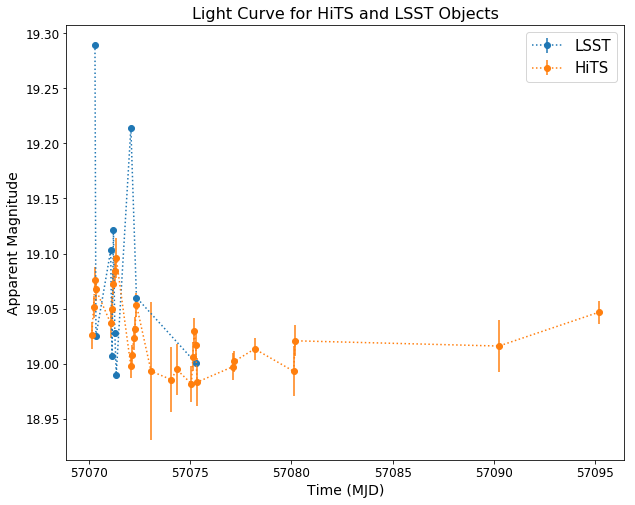

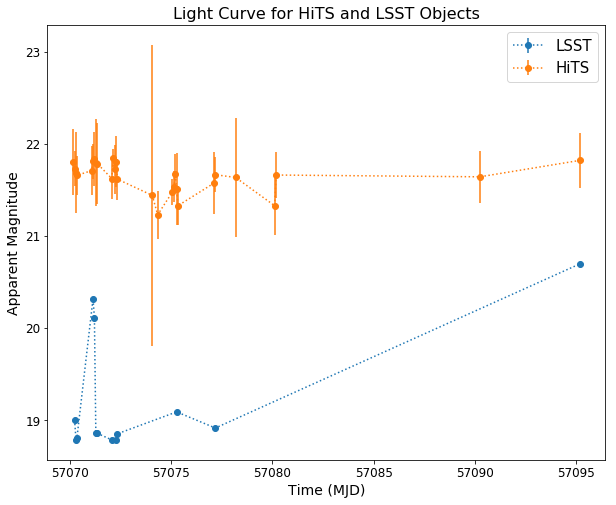

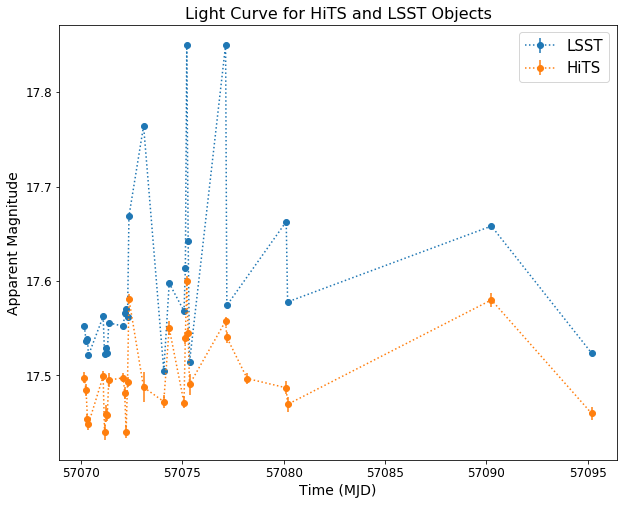

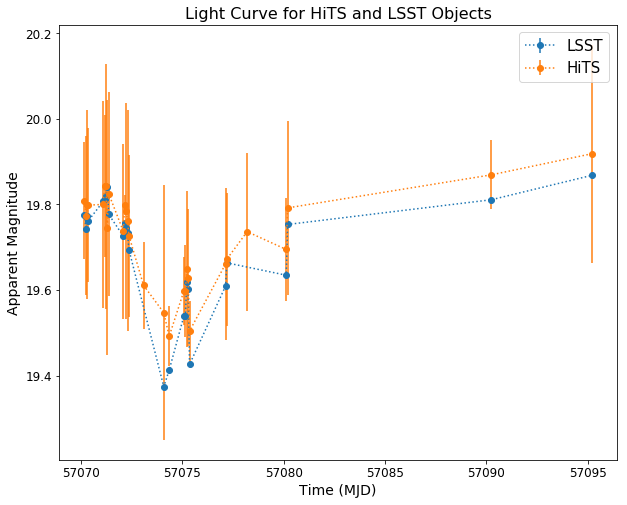

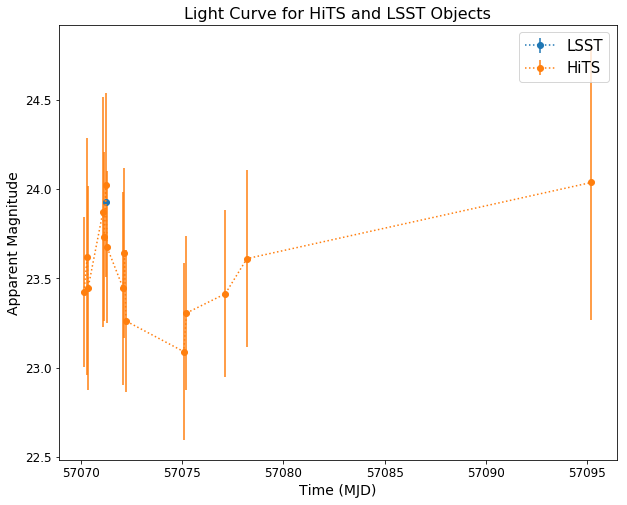

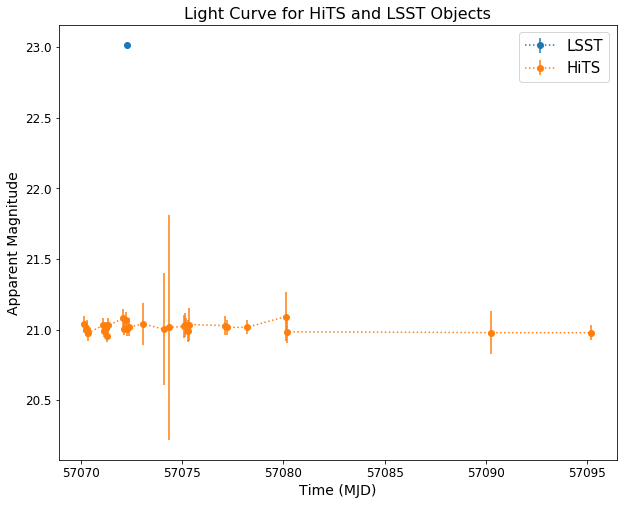

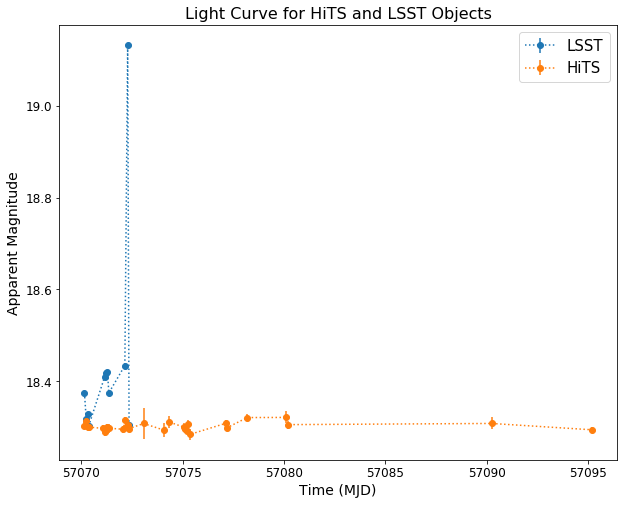

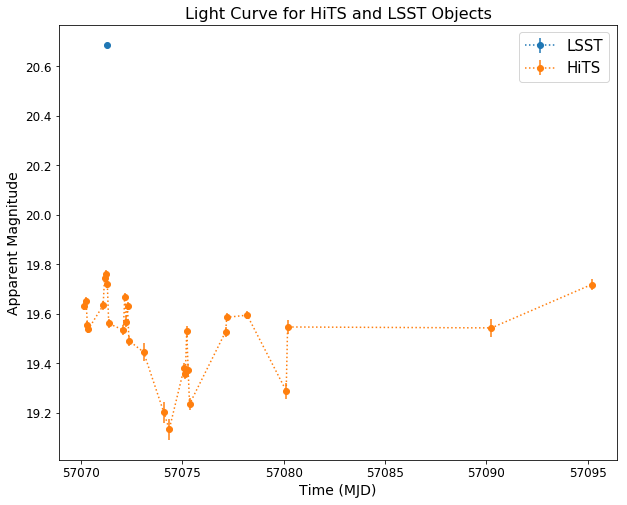

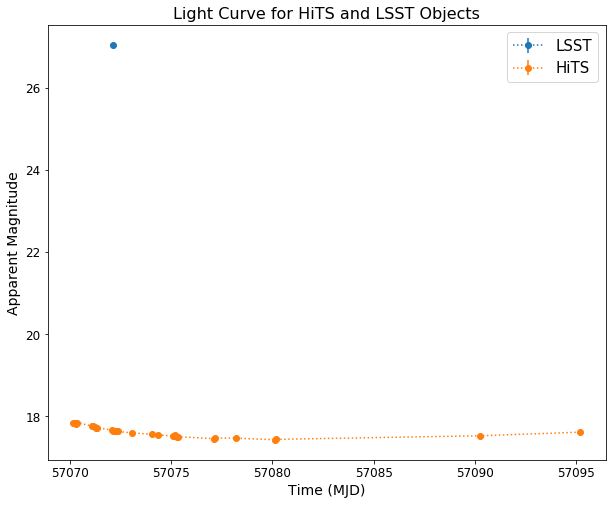

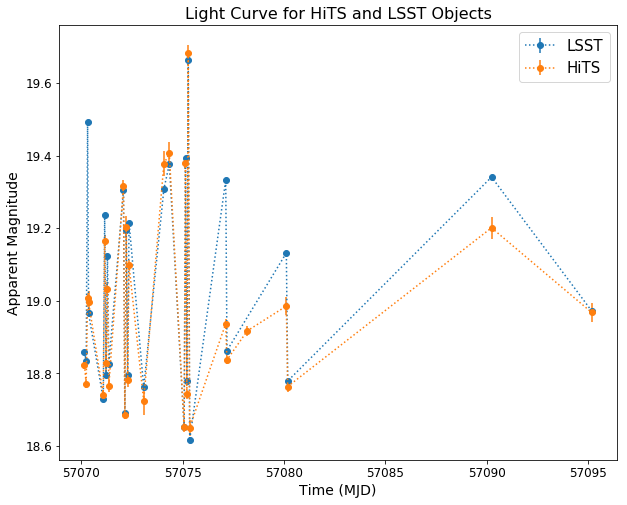

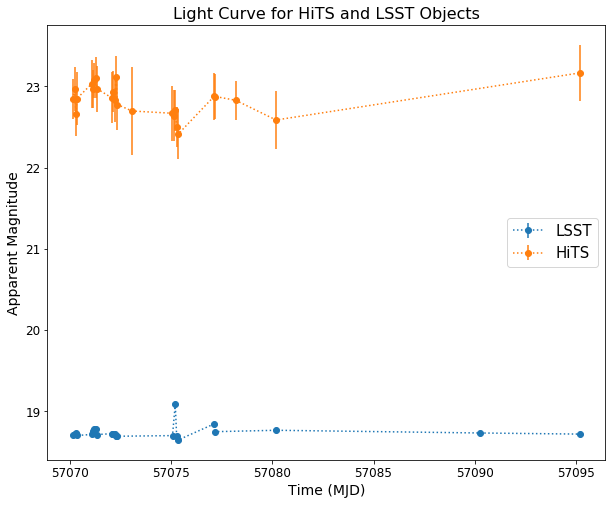

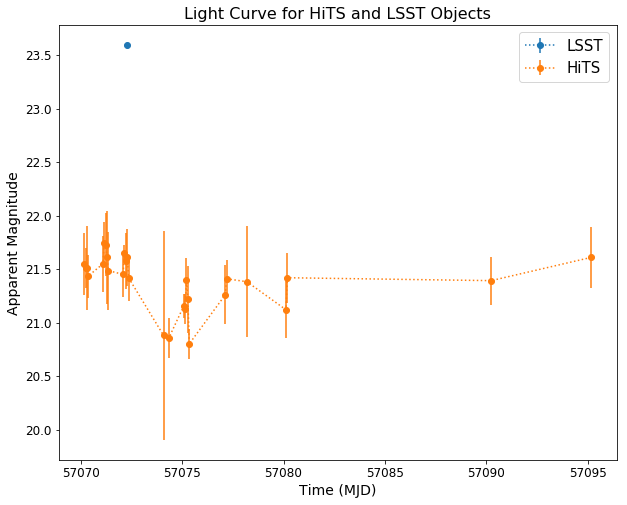

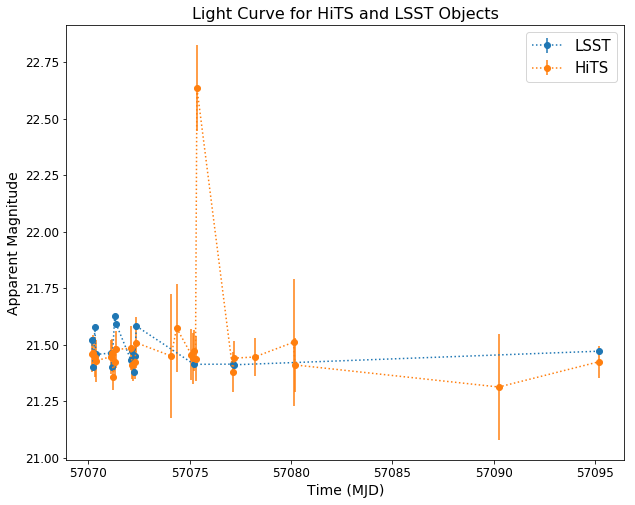

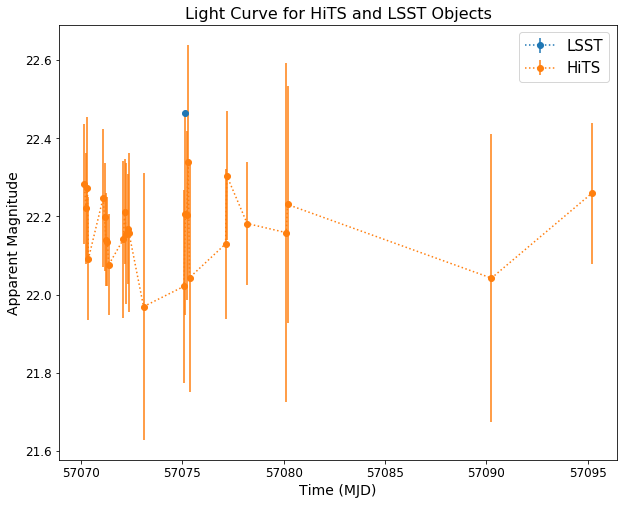

In [157]:
for i in range(60, 80):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

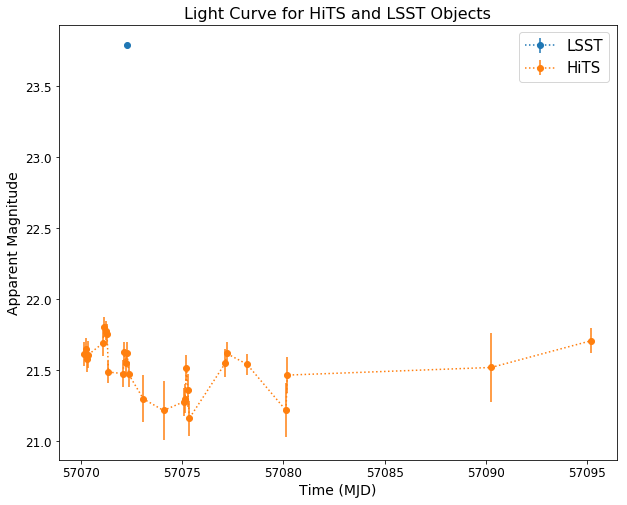

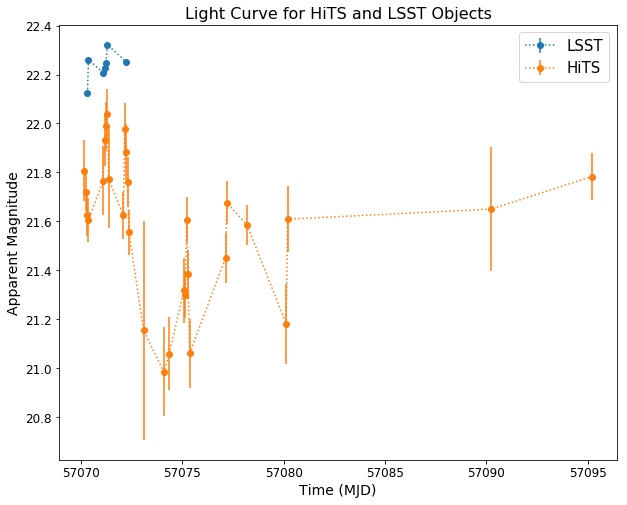

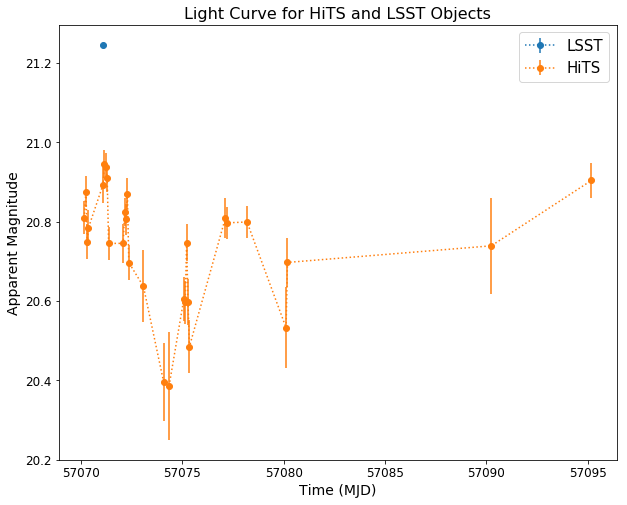

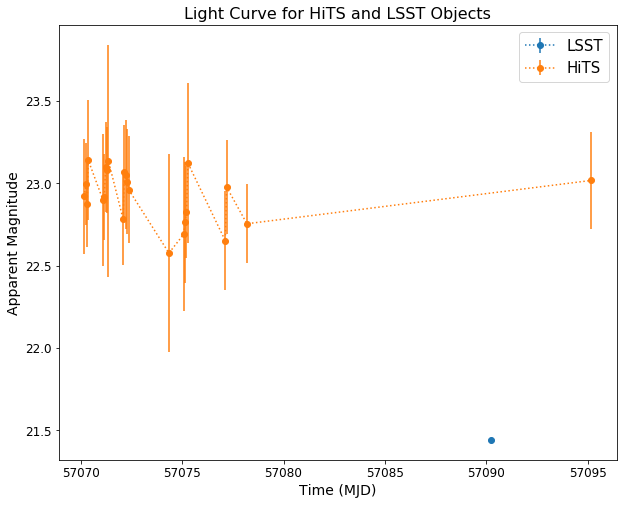

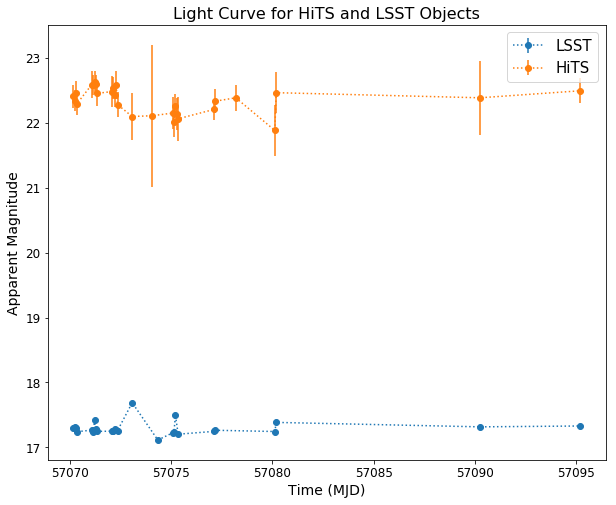

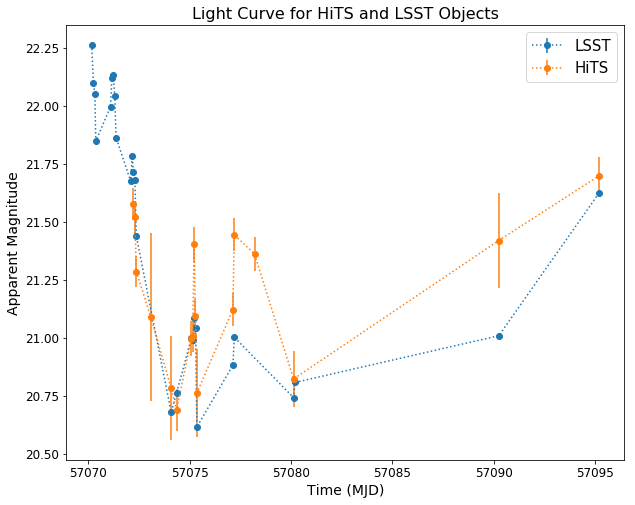

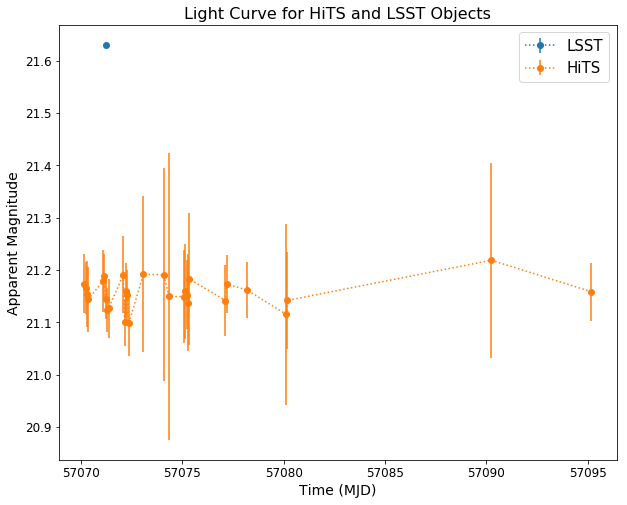

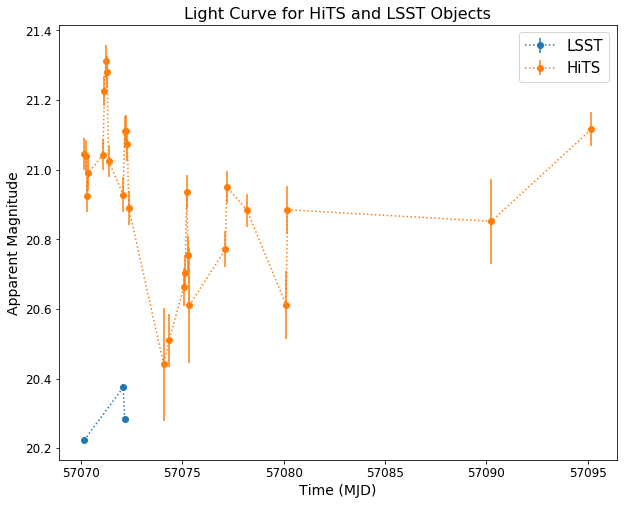

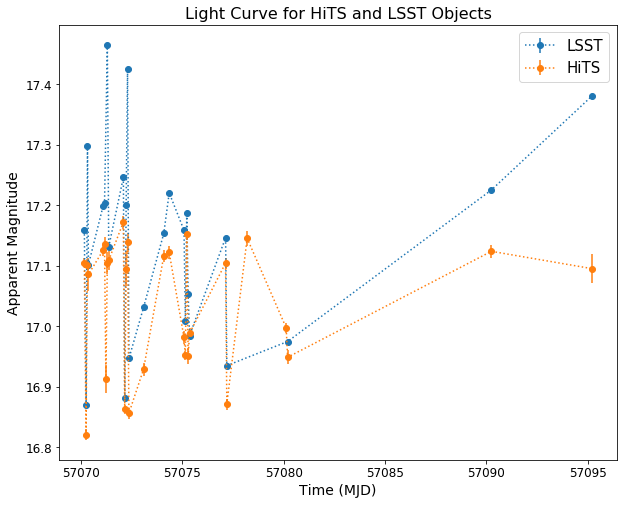

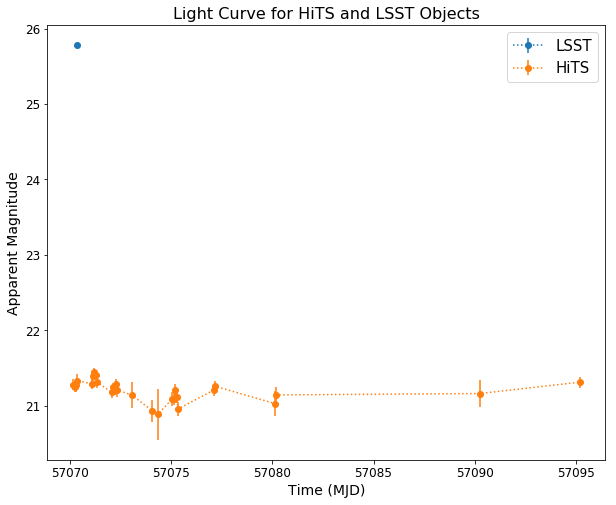

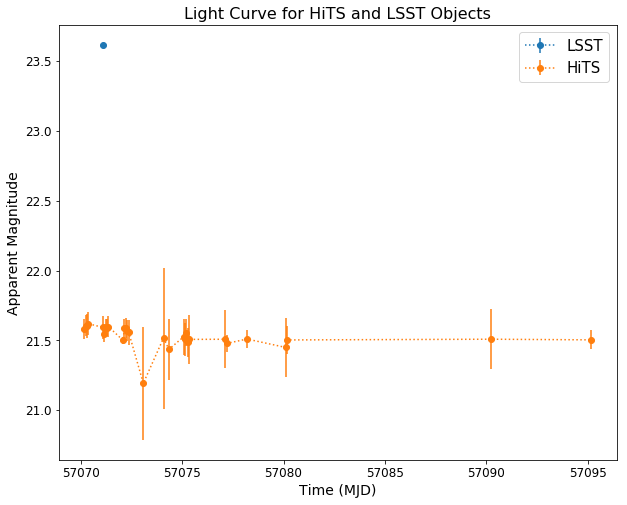

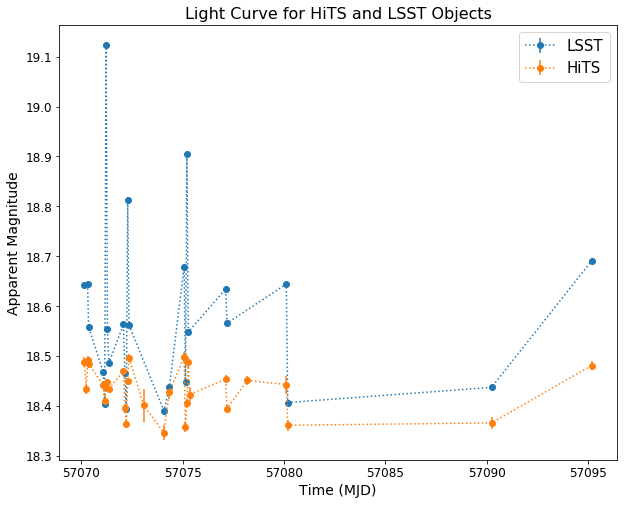

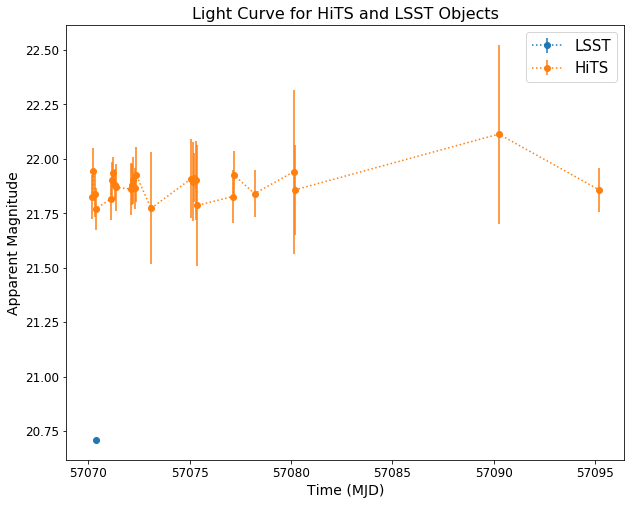

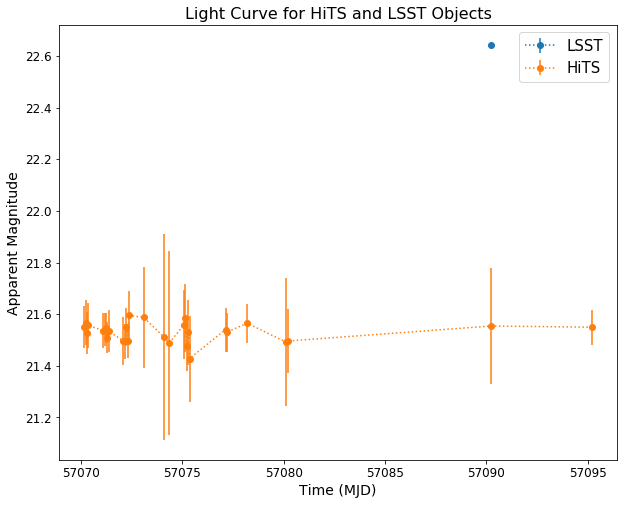

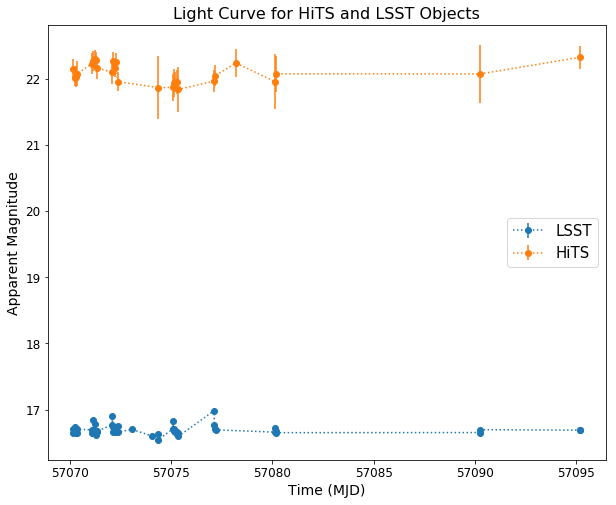

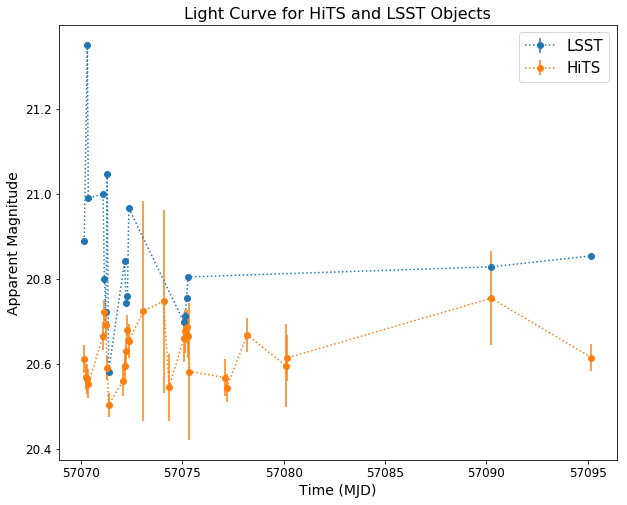

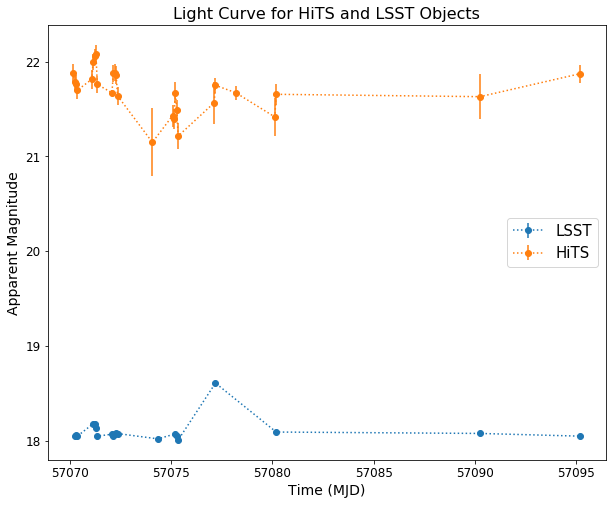

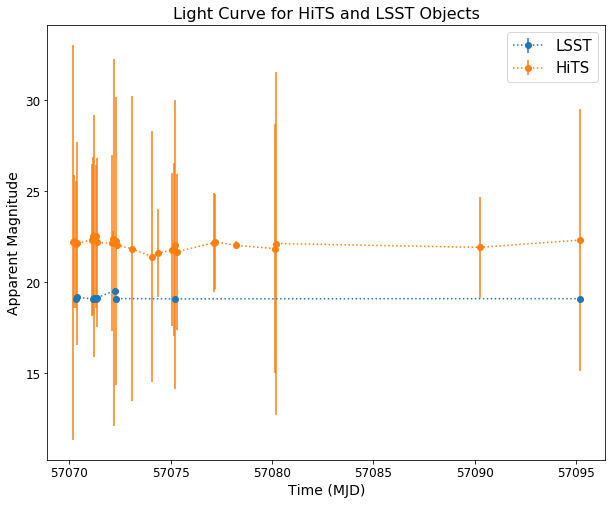

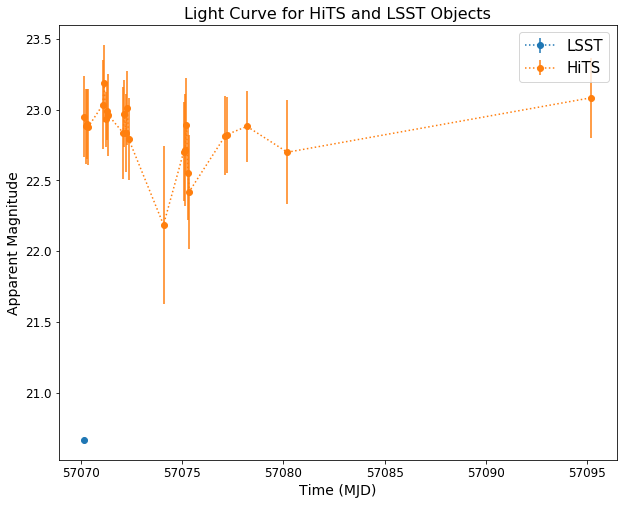

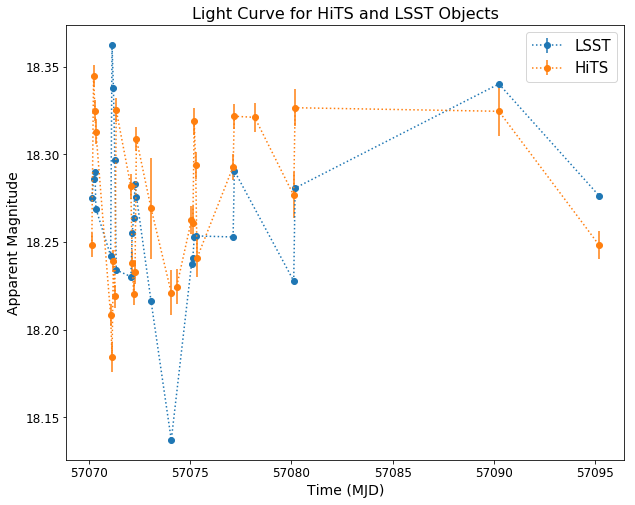

In [158]:
for i in range(80, 100):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

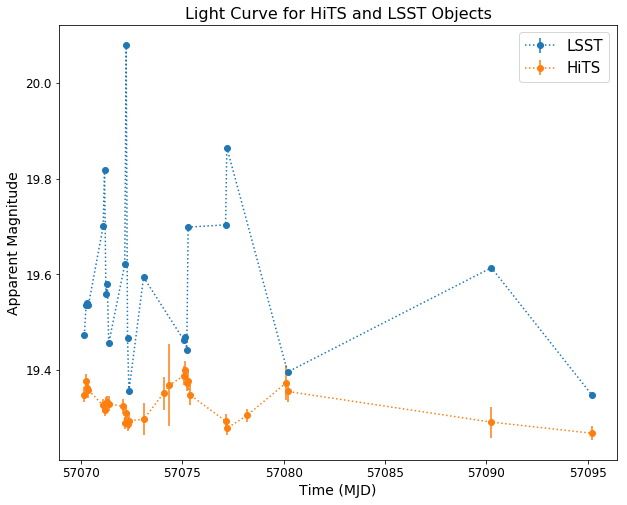

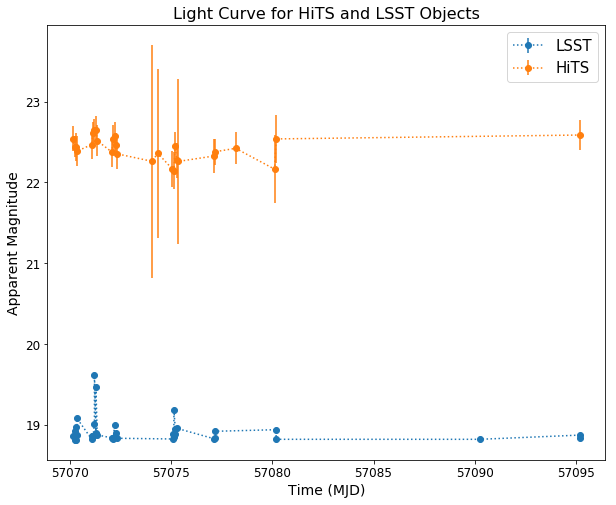

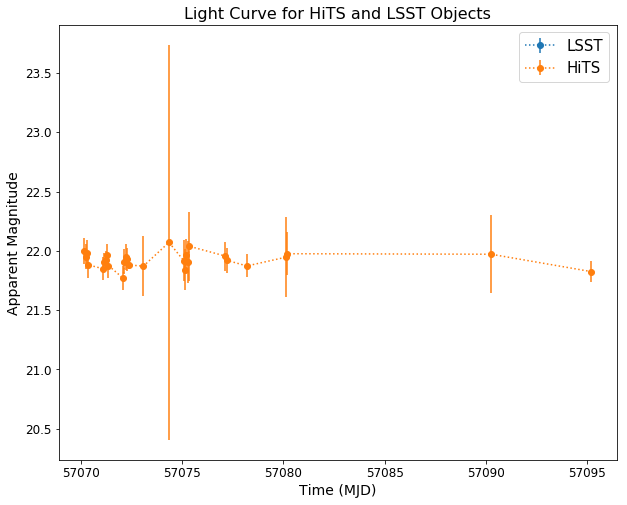

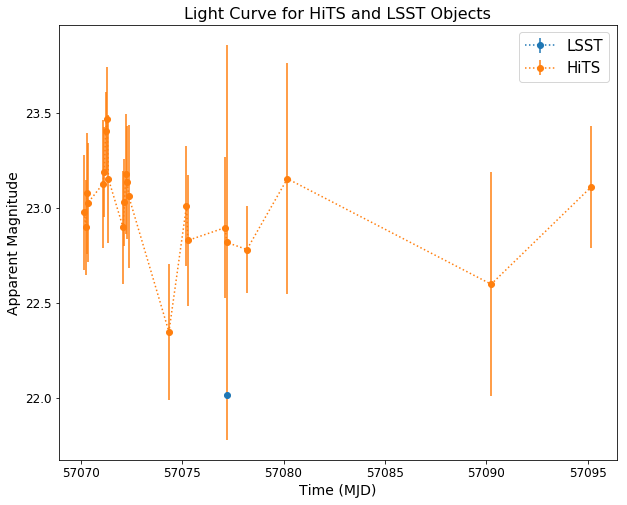

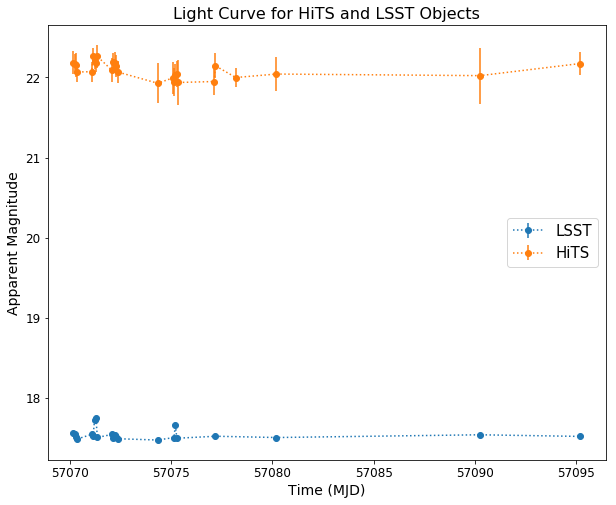

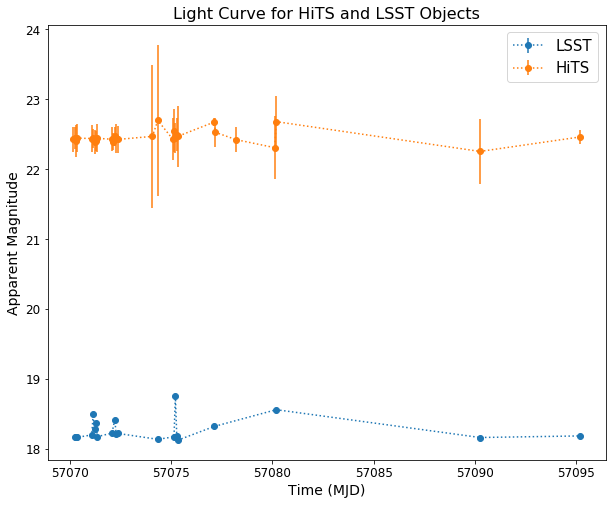

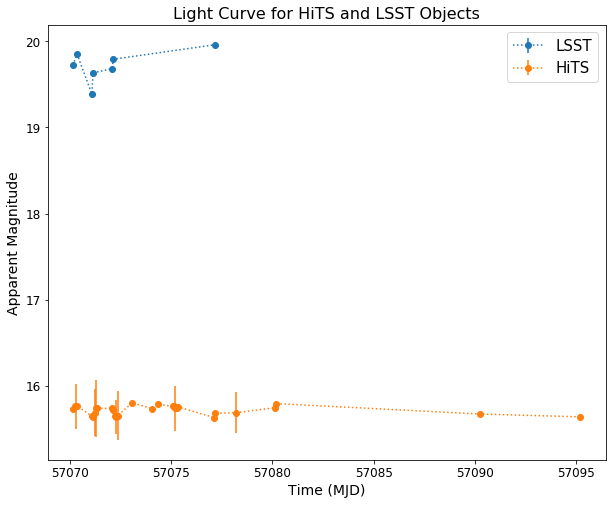

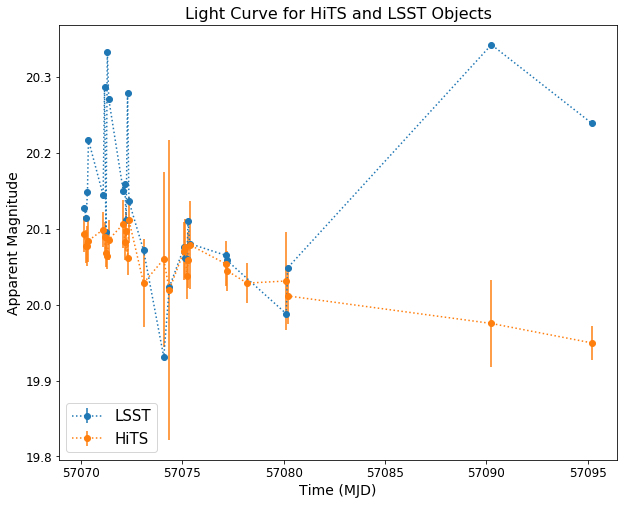

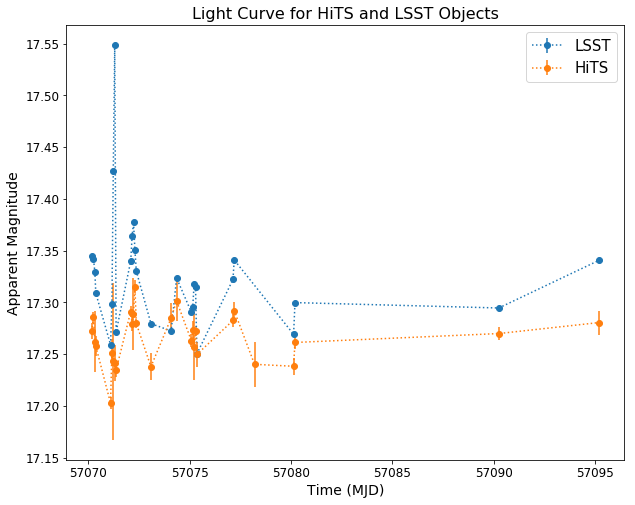

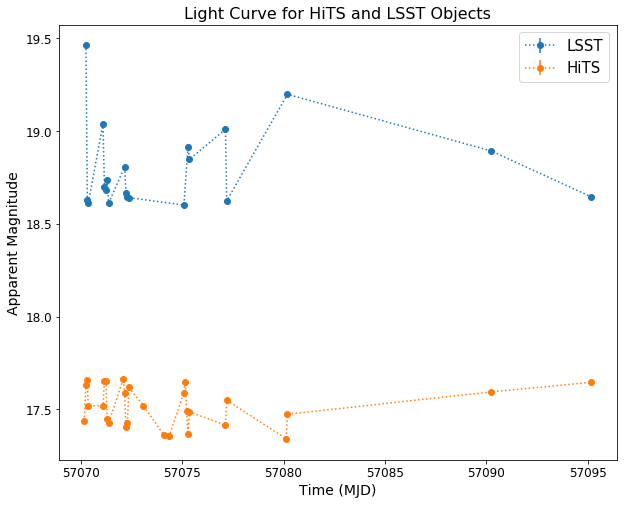

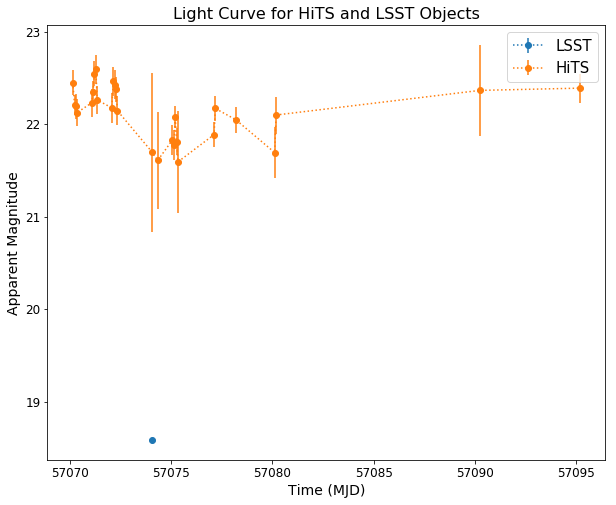

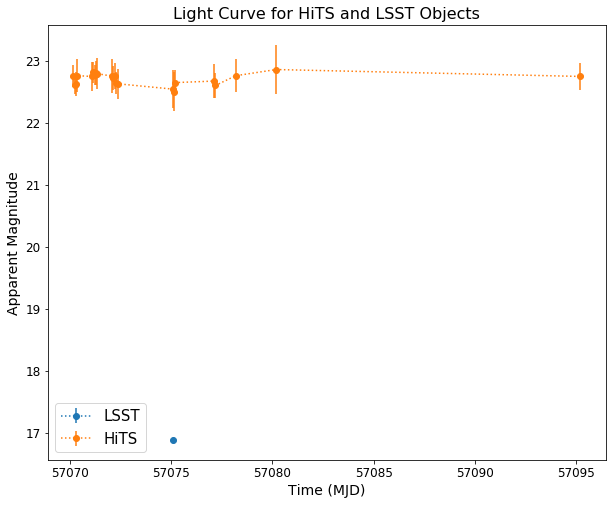

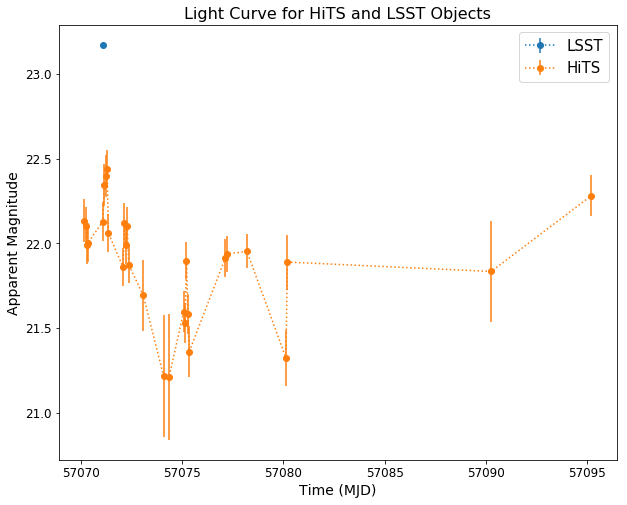

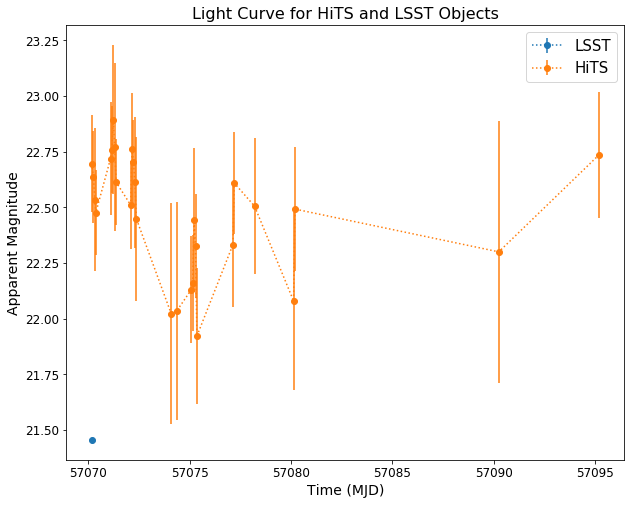

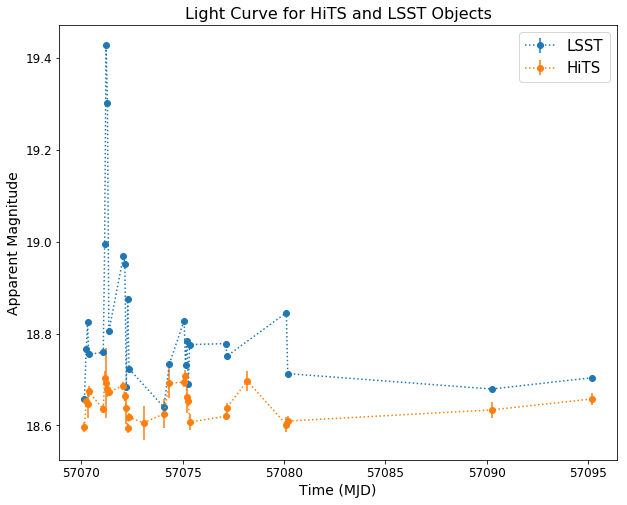

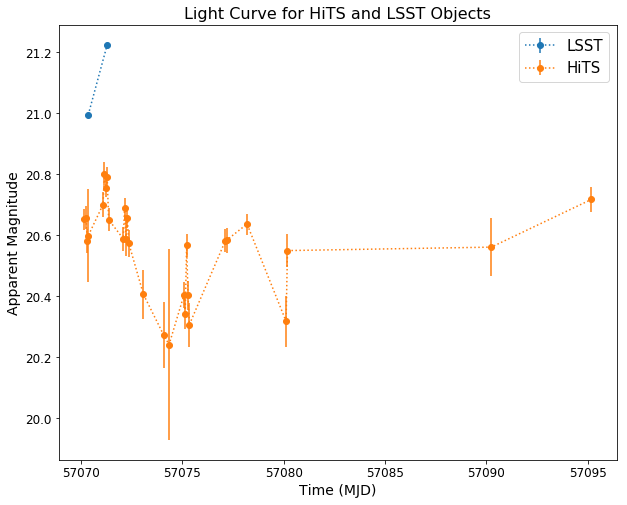

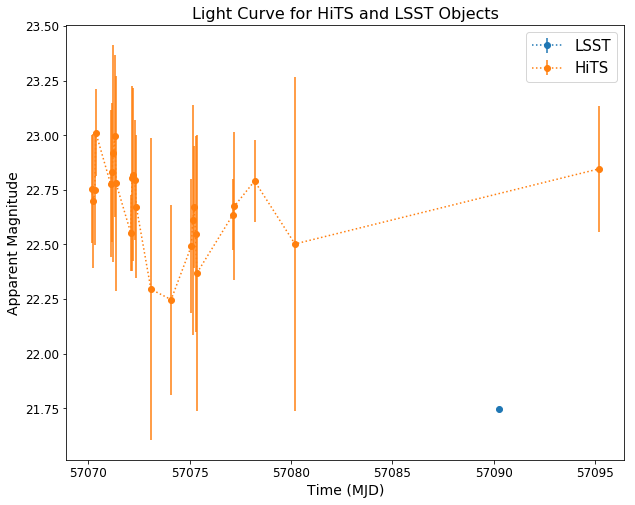

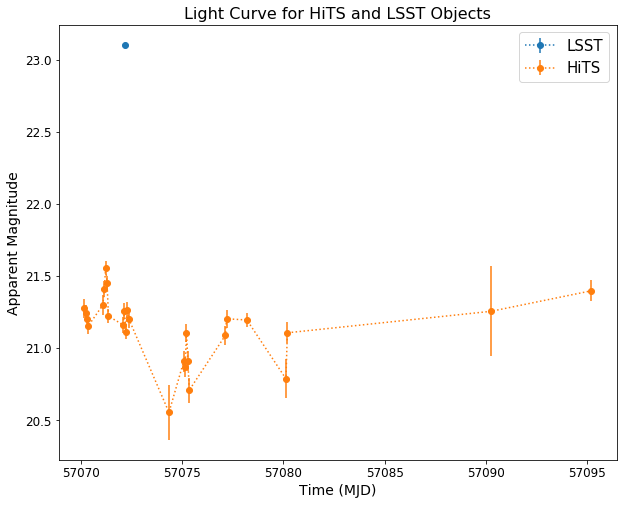

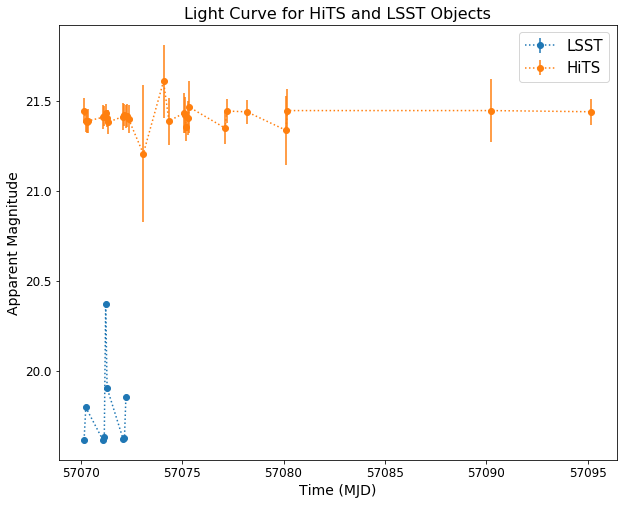

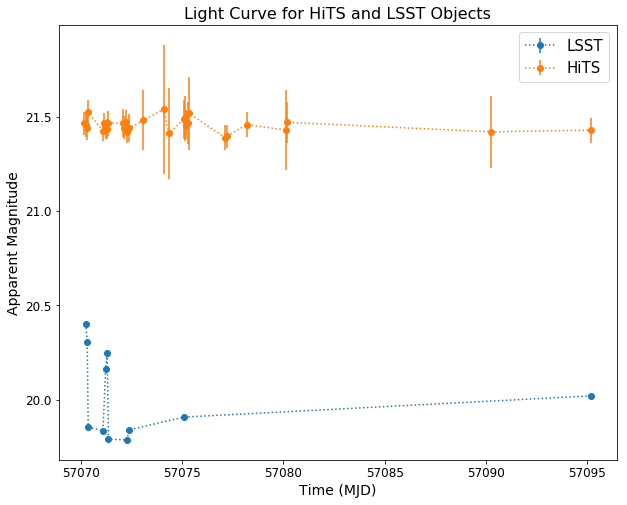

In [159]:
for i in range(100, 120):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

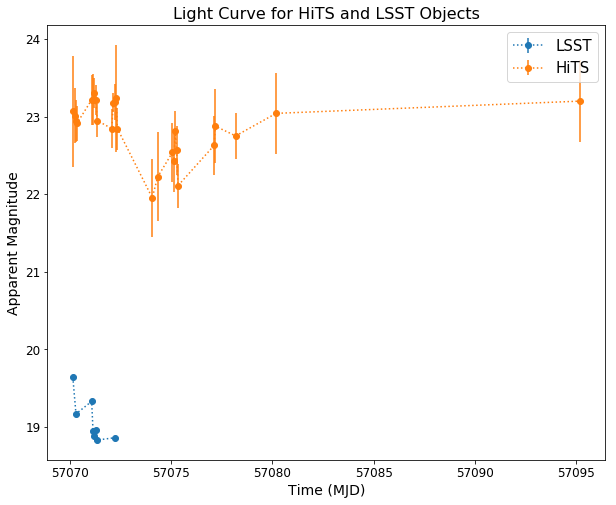

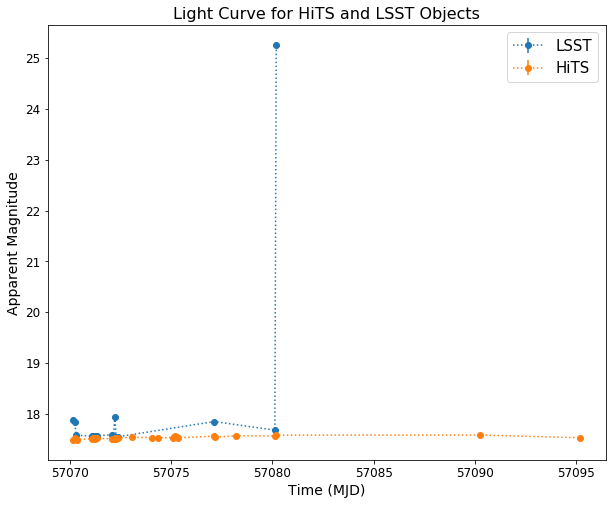

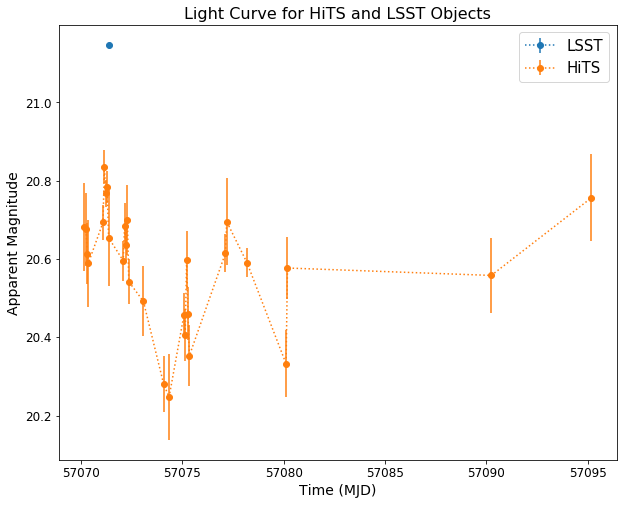

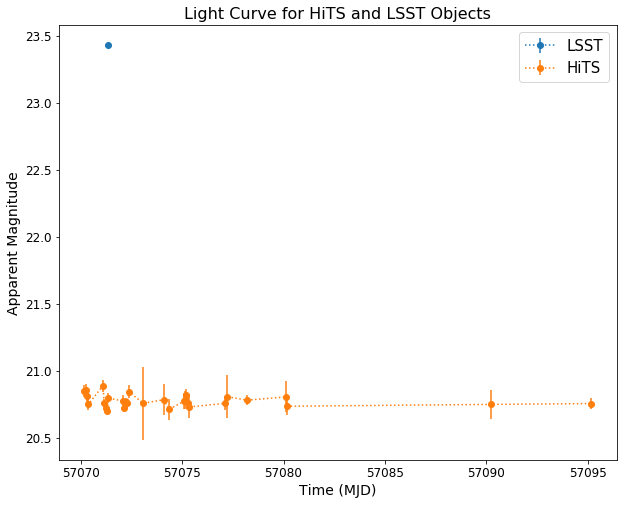

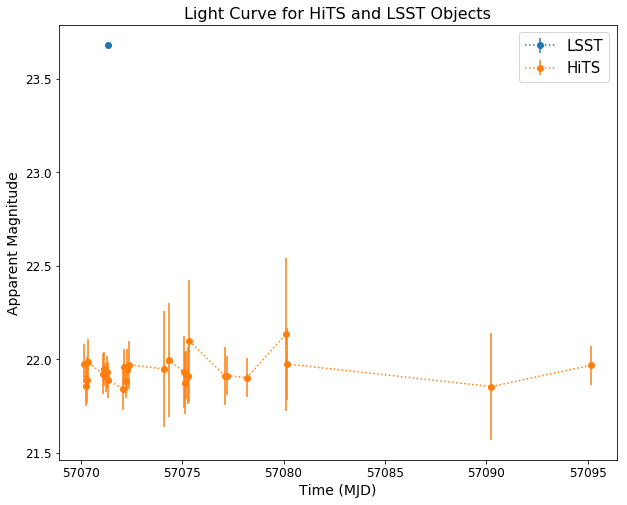

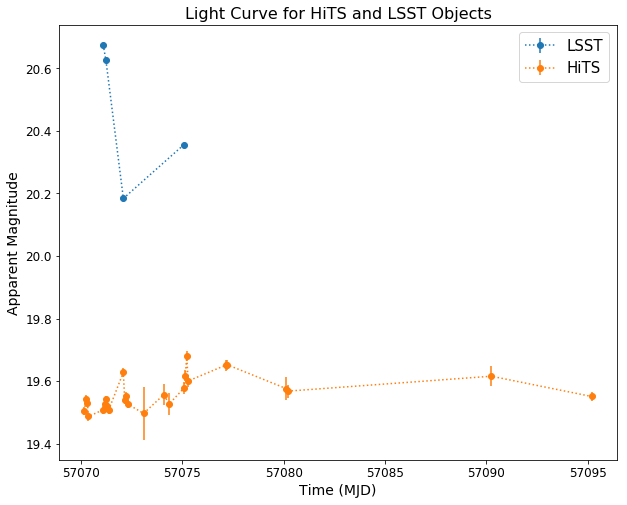

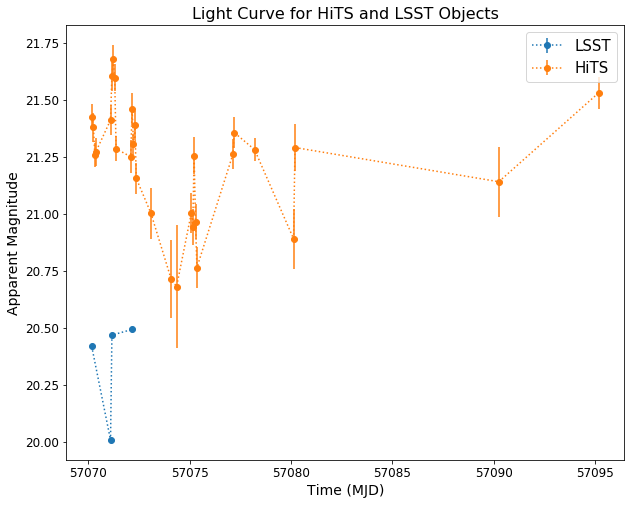

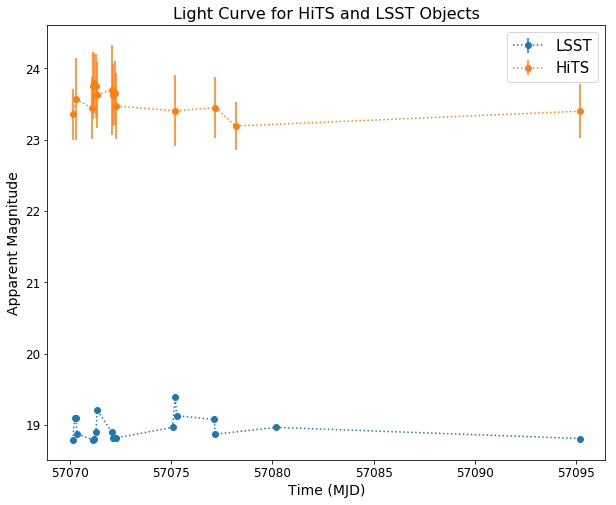

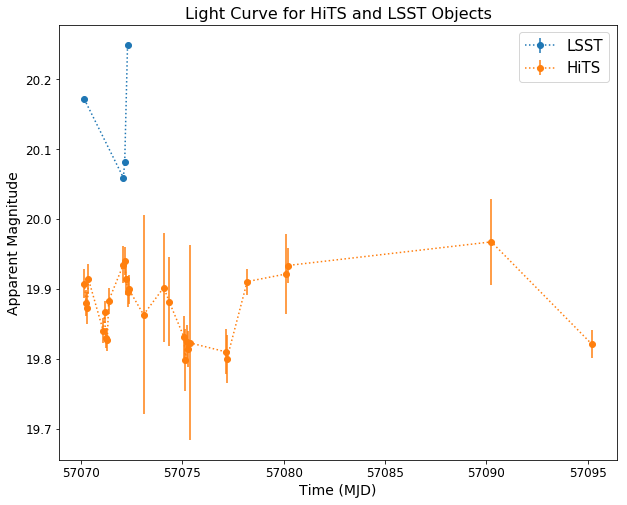

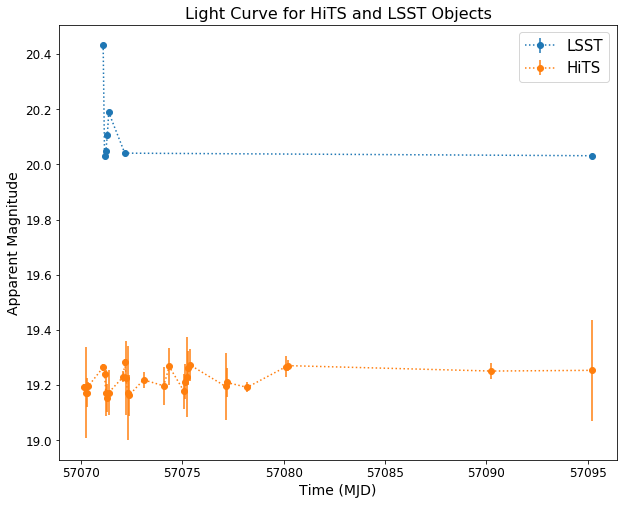

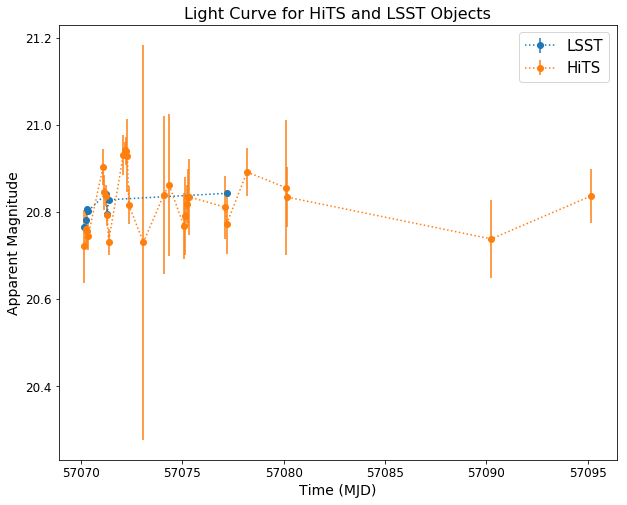

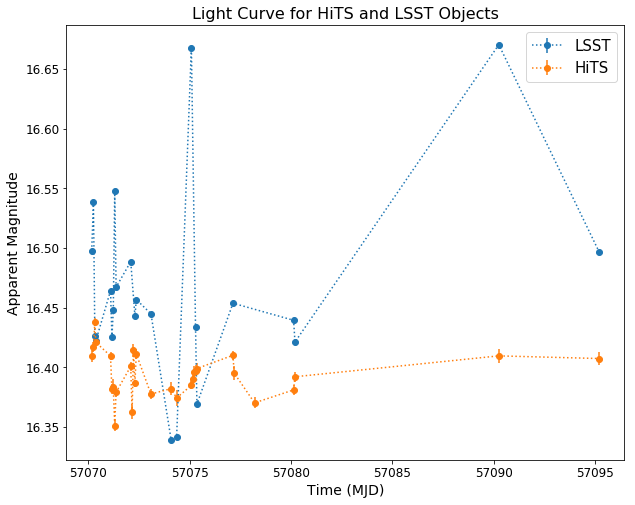

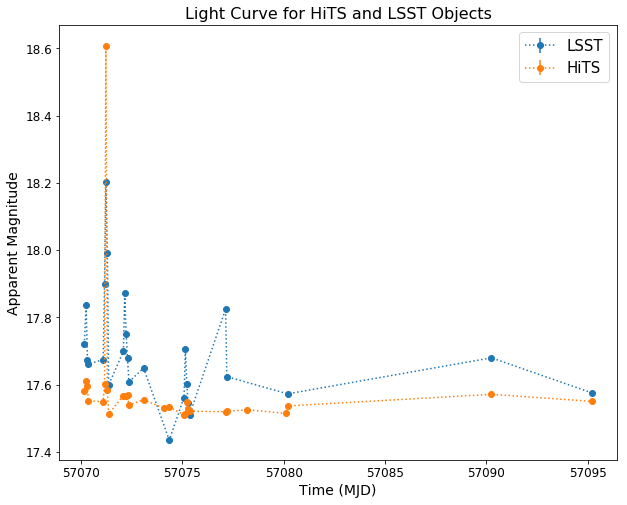

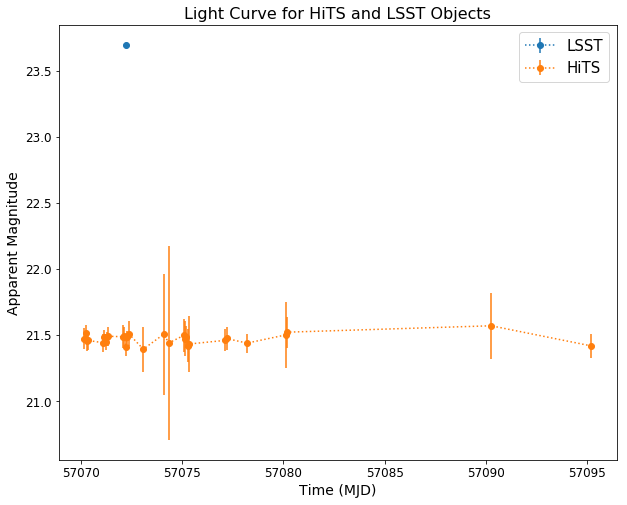

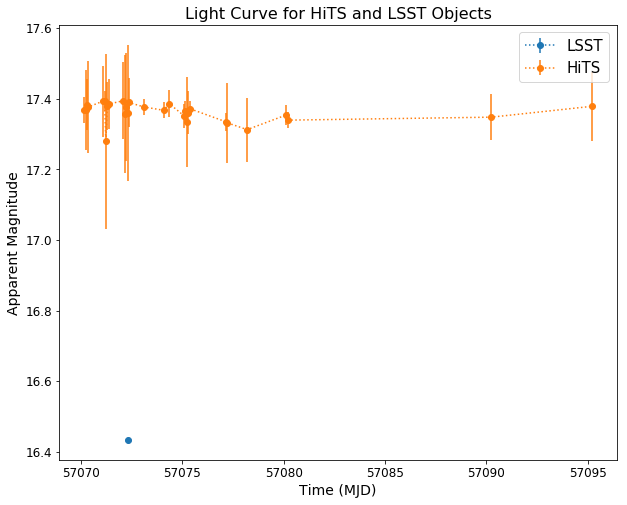

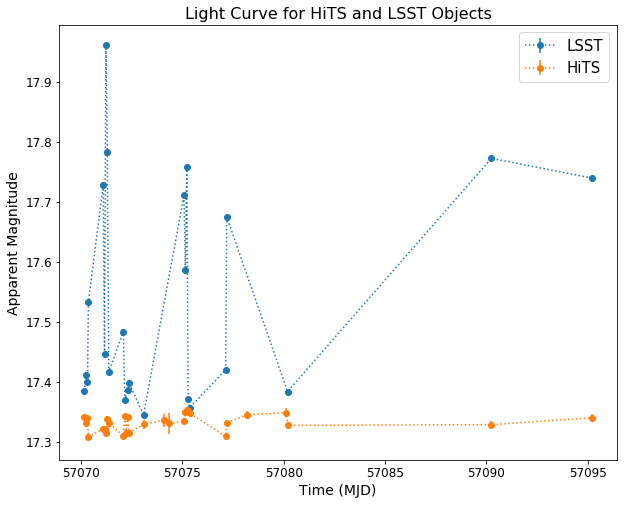

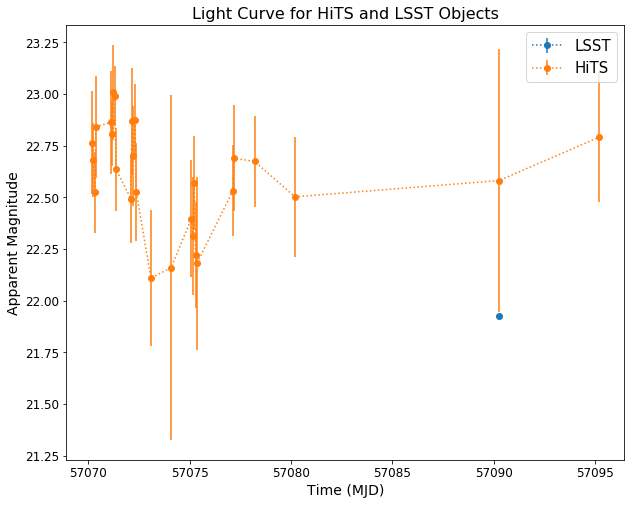

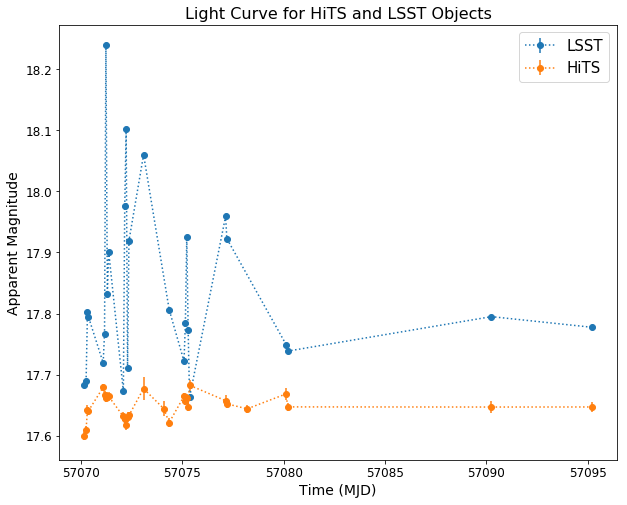

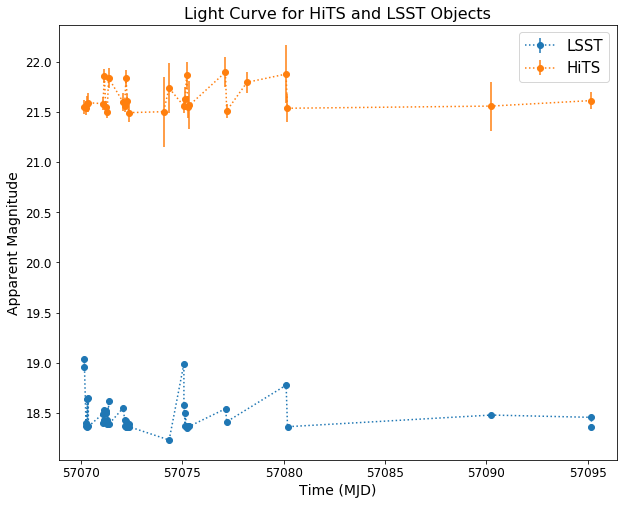

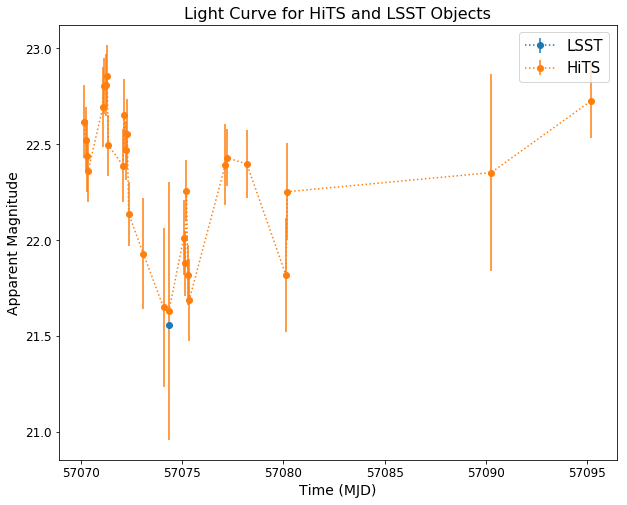

In [160]:
for i in range(120, 140):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

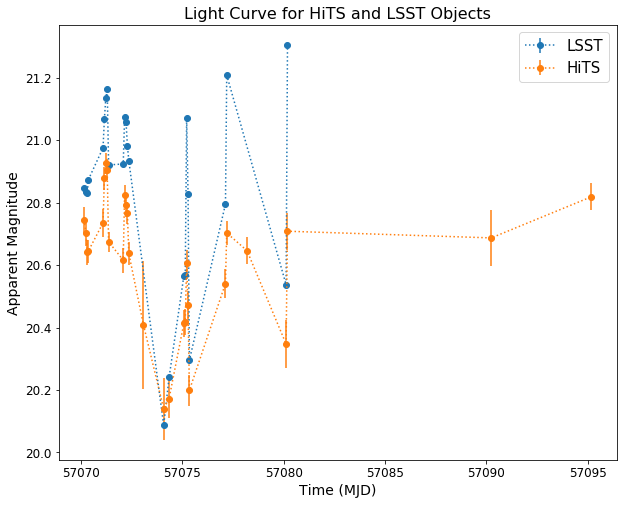

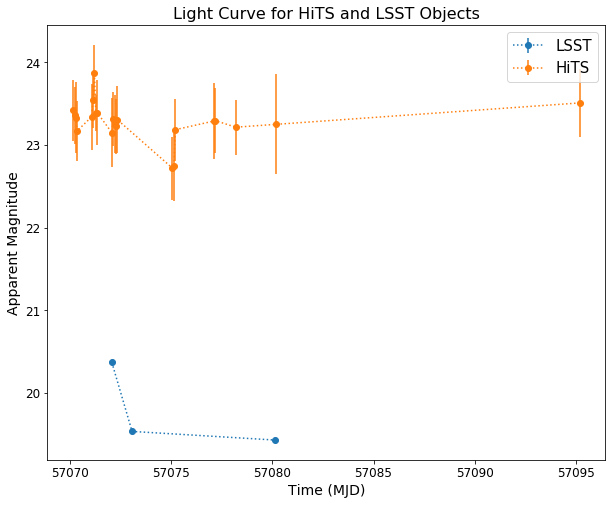

In [161]:
for i in range(140, 142):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

FileNotFoundError: [Errno 2] No such file or directory: '/epyc/users/mrawls/premap2019/hits-dr1/light_curves/Blind14A_10/N13/Blind14A_10_N13_LC_50.tar.gz'

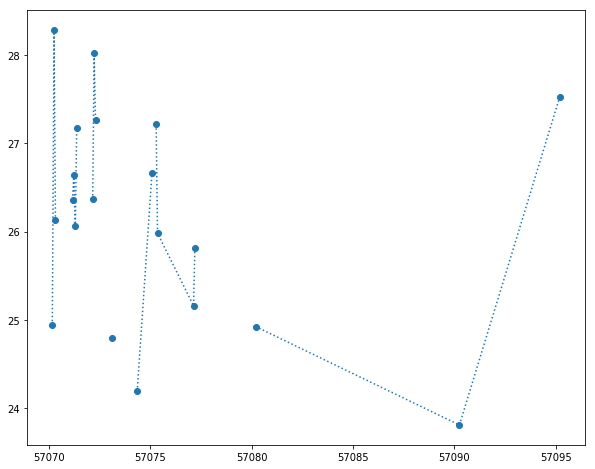

In [162]:
obj = goodObj.iloc[idx[142]]['diaObjectId']
row = hitsDf.iloc[142]
plotLsstHitsLightCurve(obj, srcTableAll, row)
# This plot appears to be missing HiTS DR1 data.

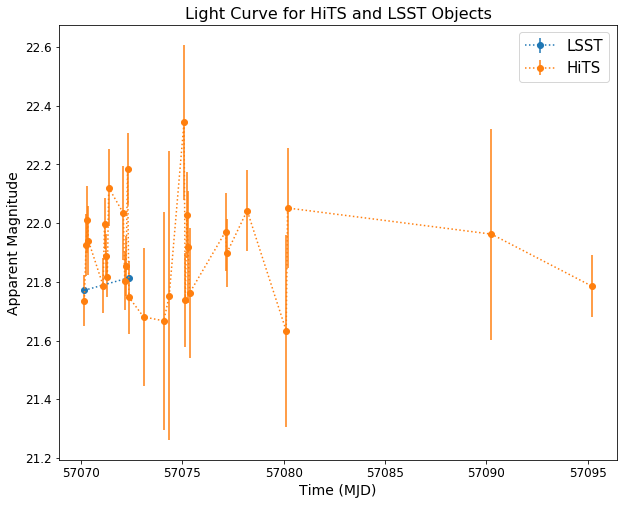

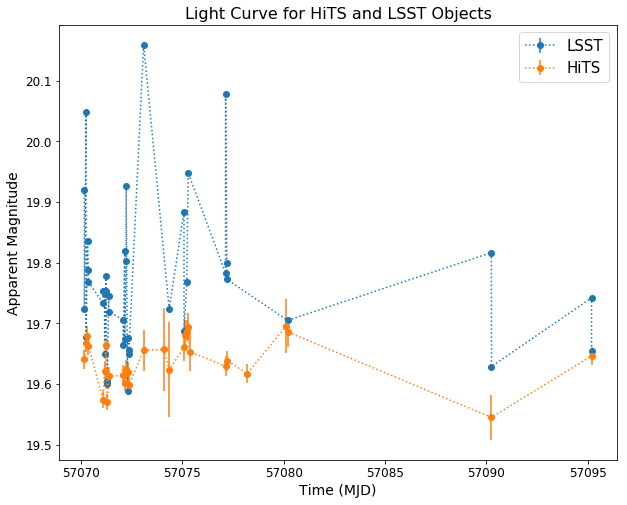

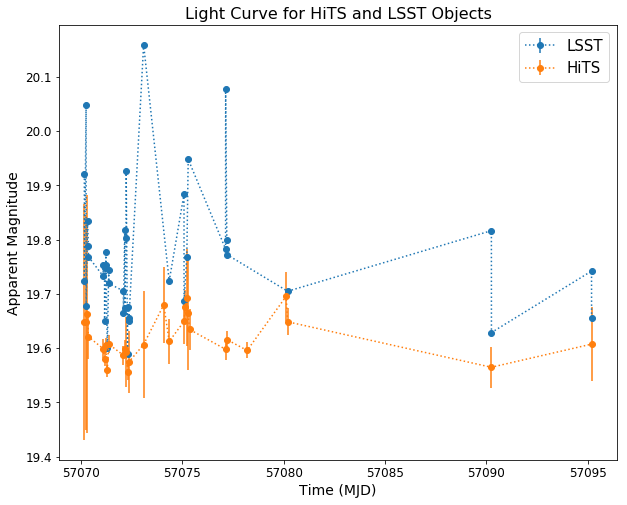

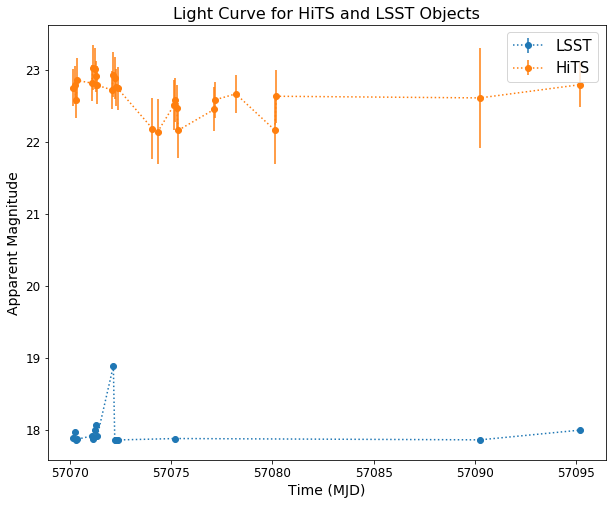

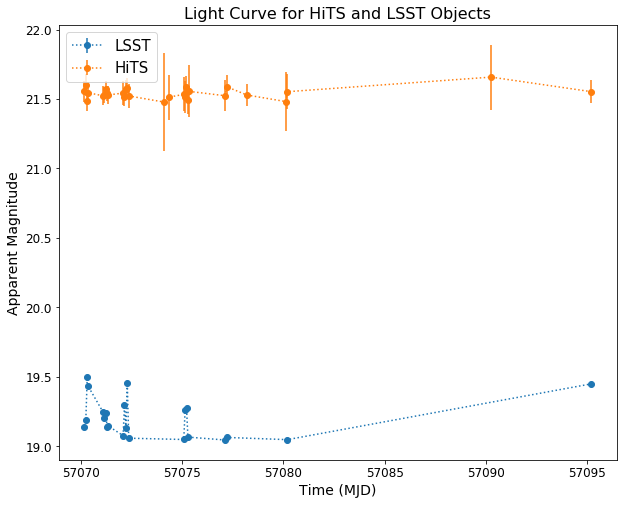

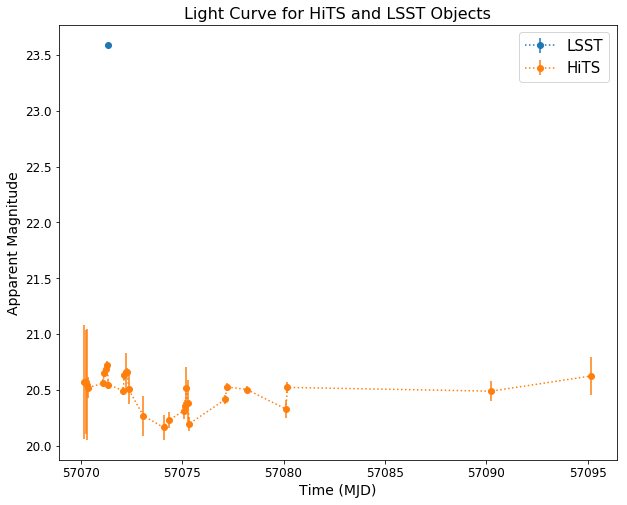

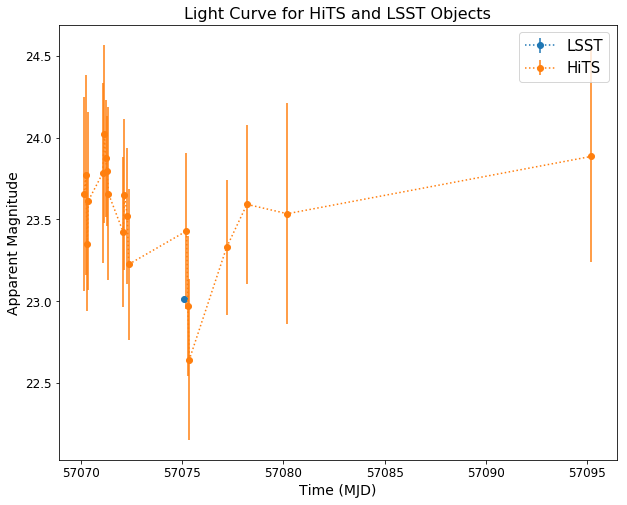

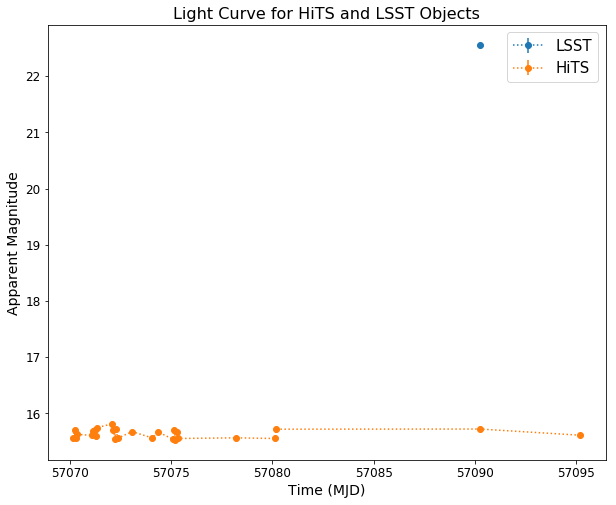

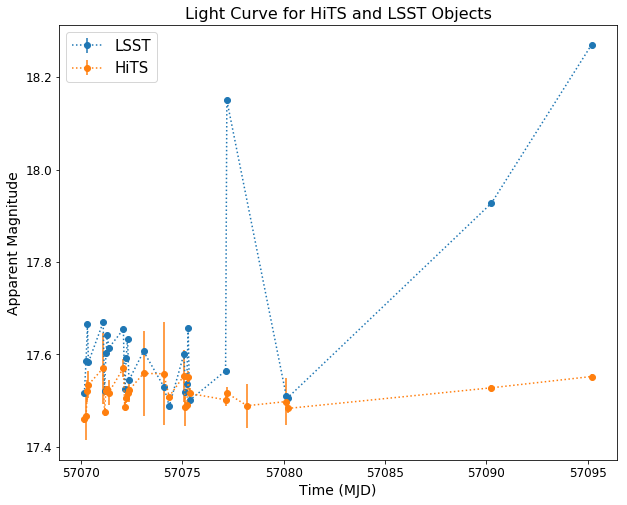

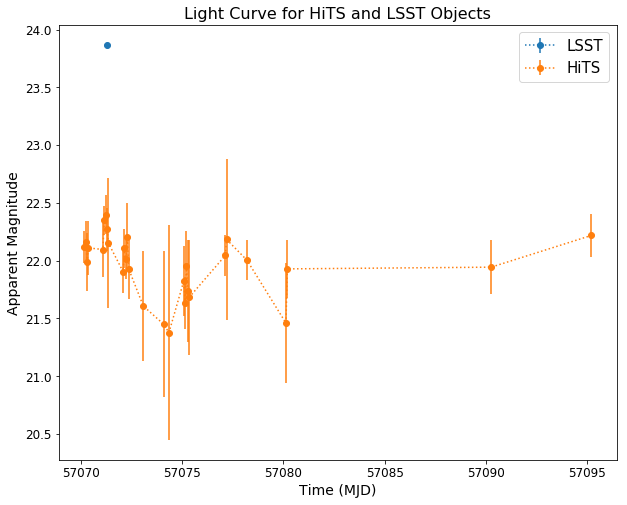

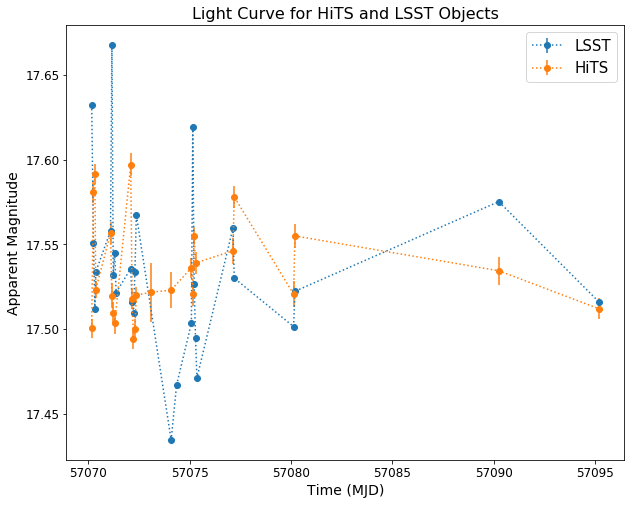

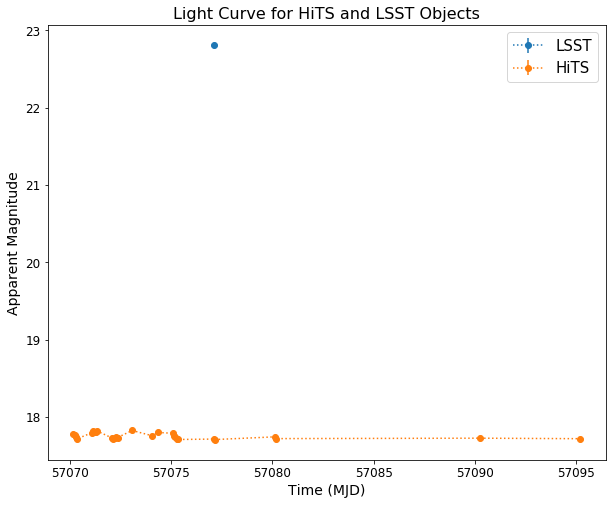

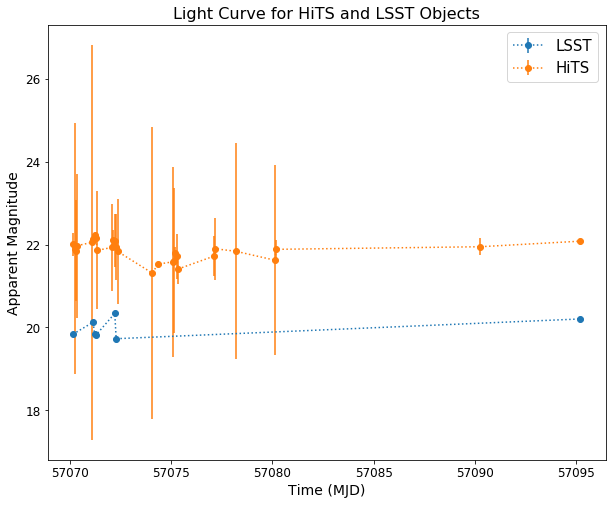

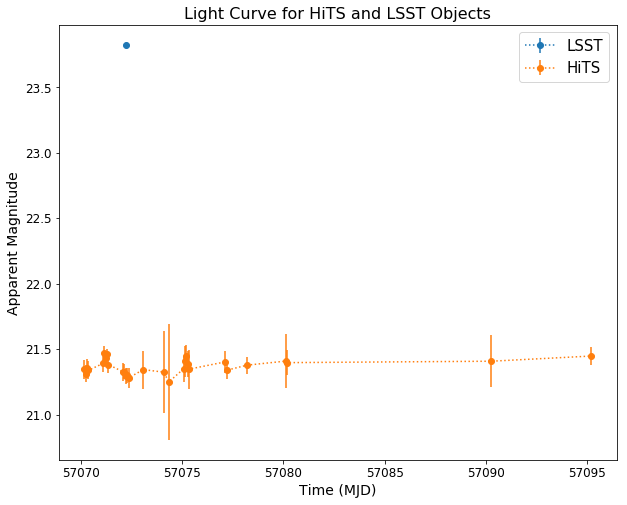

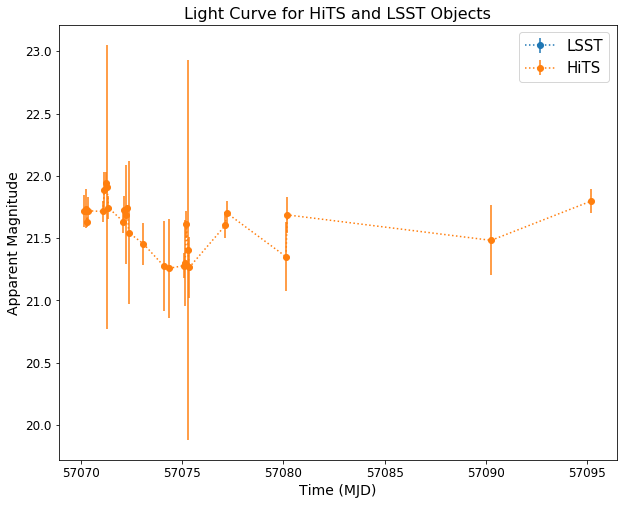

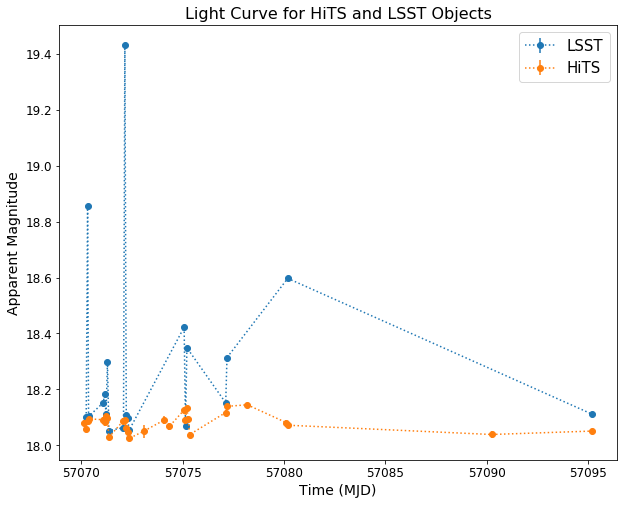

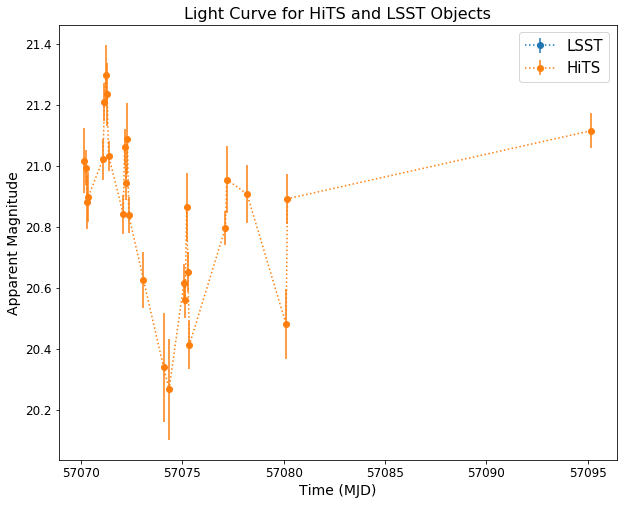

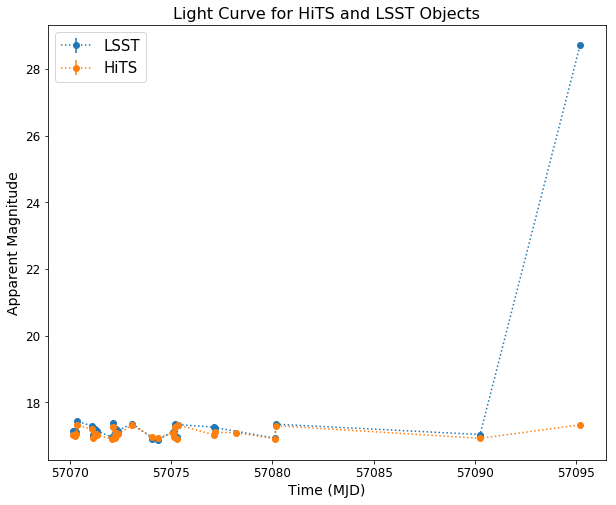

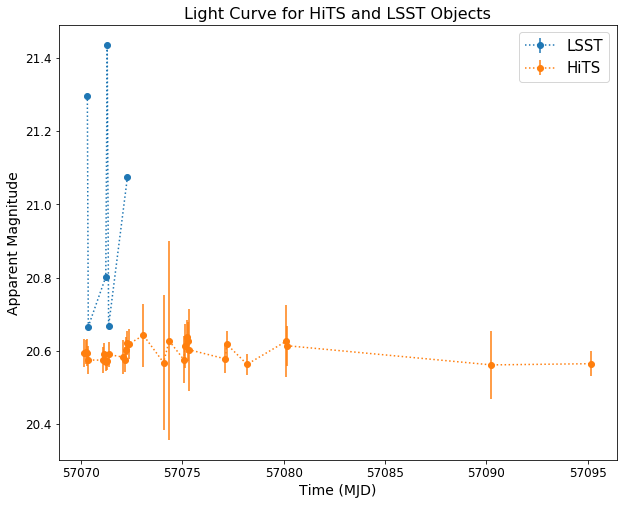

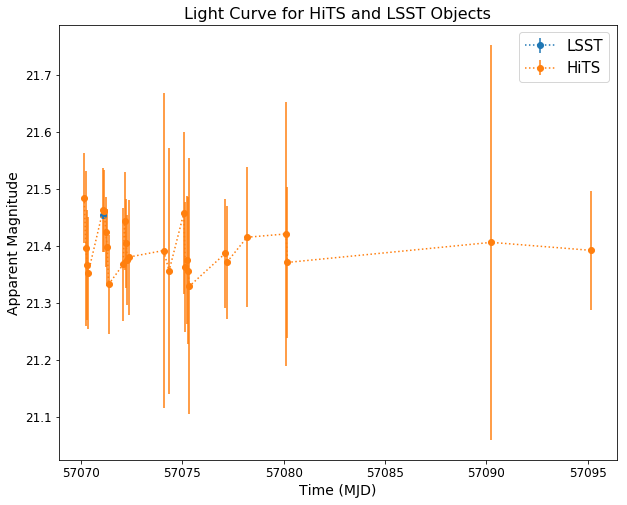

In [164]:
for i in range(143, 163):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

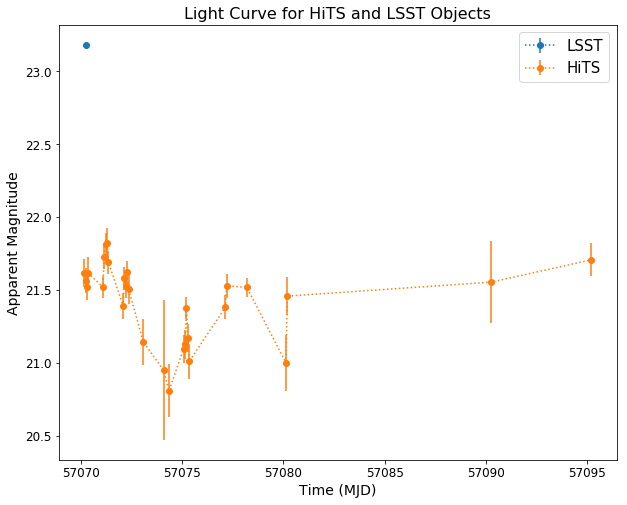

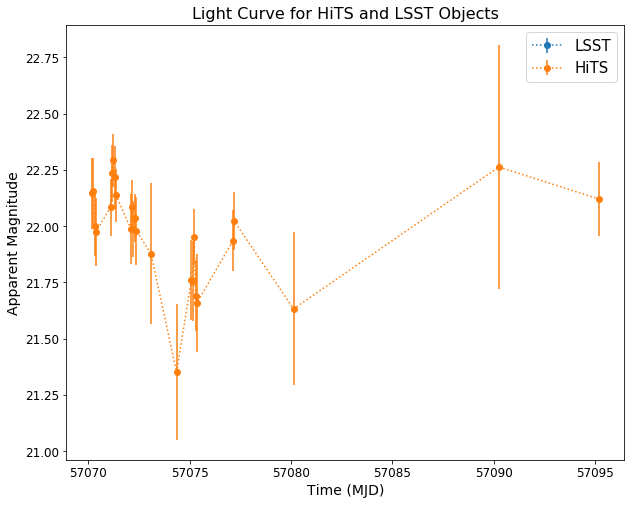

In [165]:
for i in range(163, 165):
        obj = goodObj.iloc[idx[i]]['diaObjectId']
        row = hitsDf.iloc[i]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

In [ ]:
# Preliminary list of potentially good light curves
goodCurveIdxListPotential = (2,4,11,13,24,25,32,34,39,40,41,45,46,47,49,\
                    50,52,56,58,61,63,64,66,67,68,69,70,72,75,76,\
                    78,84,85,88,91,94,95,105,106,107,108,109,114,\
                    119,127,131,132,136,138,139,140,144,145,\
                    146,147,151,153,155,158,160)
goodCurveIdxArrayPotential = np.array(goodCurveIdxListPotential) # Converting list to numpy array
len(goodCurveIdxArrayPotential)

#### Secondary Identification of Good and Bad Curves


In [ ]:
for i in range(0,20): # Plotting multiple curves from goodCurveIdxArrayPotential
        x = goodCurveIdxArrayPotential[i]
        obj = goodObj.iloc[idx[x]]['diaObjectId']
        row = hitsDf.iloc[x]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

In [ ]:
for i in range(20,40):
        x = goodCurveIdxArrayPotential[i]
        obj = goodObj.iloc[idx[x]]['diaObjectId']
        row = hitsDf.iloc[x]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

In [ ]:
for i in range(40,60):
        x = goodCurveIdxArrayPotential[i]
        obj = goodObj.iloc[idx[x]]['diaObjectId']
        row = hitsDf.iloc[x]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

In [ ]:
goodCurveIdxList = (0,1,6,7,8,13,21,25,28,32,33,40,42,46,50,56) # List of potentially good curve indices
badCurveIdxList = (4,5,11,12,14,18,23,26,27,29,31,35,37,38,41,\ # List of bad curve indices
                   43,44,47,48,49,53,54) 
suspectCurveIdxList = (2,3,9,10,15,16,17,19,20,22,24,30,34,36,\ # List of curve indices I am not sure about
                       39,45,51,52,55,57,58,59) 

# creating numpy arrays of original indices for ease of plotting

goodCurveArray = []
badCurveArray = []
suspectCurveArray = []

for i in goodCurveIdxList:
    x= goodCurveIdxArrayPotential[i]
    goodCurveArray.append(x)

for i in badCurveIdxList:
    x= goodCurveIdxArrayPotential[i]
    badCurveArray.append(x)

for i in suspectCurveIdxList:
    x= goodCurveIdxArrayPotential[i]
    suspectCurveArray.append(x)

In [ ]:
for i in range(len(goodCurveArray)):
        x = goodCurveArray[i]
        obj = goodObj.iloc[idx[x]]['diaObjectId']
        row = hitsDf.iloc[x]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

In [ ]:
for i in range(0,20):
        x = suspectCurveArray[i]
        obj = goodObj.iloc[idx[x]]['diaObjectId']
        row = hitsDf.iloc[x]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

In [ ]:
for i in range(20,22):
        x = suspectCurveArray[i]
        obj = goodObj.iloc[idx[x]]['diaObjectId']
        row = hitsDf.iloc[x]
        plotLsstHitsLightCurve(obj, srcTableAll, row)

#### Final List of Good Light Curves

In [ ]:
# Go through "good" and suspect curves with Dr. Rawls